# Day 2: Model Implementation (No References)

**Time:** 4-5 hours

This version has NO reference implementations. You'll need to figure it out from:
- The docstrings and hints
- The test cells (they tell you expected behavior)
- Your Day 1 knowledge

## Architecture Overview

```
ENCODER (compresses):
256×256×1 → 128×128×64 → 64×64×128 → 32×32×256 → 16×16×64

DECODER (reconstructs):
16×16×64 → 32×32×256 → 64×64×128 → 128×128×64 → 256×256×1
```

---

## Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


---

# Part 1: Encoder (45 minutes)

## 1.1 ConvBlock

Build a block that does: **Conv2d → BatchNorm → LeakyReLU**

Hints:
- `nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding, bias=...)`
- `nn.BatchNorm2d(num_features)`
- `nn.LeakyReLU(negative_slope)`
- If using BatchNorm, set `bias=False` in Conv2d (BN has its own bias)

In [2]:
class ConvBlock(nn.Module):
    """
    Conv2d → BatchNorm → LeakyReLU
    
    Default params create a block that halves spatial dimensions:
    - kernel_size=5, stride=2, padding=2
    - LeakyReLU slope = 0.2
    """
    
    def __init__(self, in_channels, out_channels, kernel_size=5,
                 stride=2, padding=2, use_bn=True):
        super().__init__()
        
        # TODO: Create self.conv, self.bn, self.activation
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias = not use_bn)
        self.bn = nn.BatchNorm2d(out_channels) if use_bn else nn.Identity()
        self.activation = nn.LeakyReLU(negative_slope=0.2)
    
    def forward(self, x):
        # TODO: Apply conv → bn → activation
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x

In [3]:
# TEST
def test_conv_block():
    block = ConvBlock(1, 64)
    x = torch.randn(2, 1, 256, 256)
    y = block(x)
    assert y.shape == (2, 64, 128, 128), f"Expected (2,64,128,128), got {y.shape}"
    print(f"✓ ConvBlock: {x.shape} → {y.shape}")

test_conv_block()

✓ ConvBlock: torch.Size([2, 1, 256, 256]) → torch.Size([2, 64, 128, 128])


## 1.2 SAREncoder

Stack 4 ConvBlocks. The last one should be a plain Conv2d (no BN, no activation).

```
Layer 1: 1 → 64 channels
Layer 2: 64 → 128 channels  
Layer 3: 128 → 256 channels
Layer 4: 256 → latent_channels (just Conv2d, no activation)
```

In [4]:
class SAREncoder(nn.Module):
    """
    Encoder: 256×256×1 → 16×16×latent_channels
    
    4 layers, each halves spatial dimensions.
    Last layer has no activation (latent should be unbounded).
    """
    
    def __init__(self, in_channels=1, latent_channels=64, base_channels=64, use_bn = True):
        super().__init__()
        self.in_channels = in_channels
        self.latent_channels = latent_channels
        # TODO: Create 4 layers
        # Hint: Use ConvBlock for layers 1-3, plain nn.Conv2d for layer 4
        channels = [in_channels, base_channels, base_channels*2, base_channels*4]

        self.layer1 = ConvBlock(
            channels[0], channels[1],
            kernel_size=5, stride=2, padding=2, use_bn=use_bn
        )

        self.layer2 = ConvBlock(
            channels[1], channels[2],
            kernel_size=5, stride=2, padding=2, use_bn=use_bn
        )

        self.layer3 = ConvBlock(
            channels[2], channels[3],
            kernel_size=5, stride=2, padding=2, use_bn=use_bn
        )

        self.layer4 = nn.Conv2d(
            channels[3], latent_channels,
            kernel_size=5, stride=2, padding=2
        )
        
        self._initialise_weights()

    def _initialise_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="leaky_relu")
            
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
        
    
    def forward(self, x):
        # TODO
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x
    
    def calcreceptivefield(self):
        rf = 5  
        stride_product = 2
        for _ in range(3): 
            rf += (5 - 1) * stride_product
            stride_product *= 2
        return rf

In [5]:
# TEST
def test_encoder():
    encoder = SAREncoder(latent_channels=64)
    x = torch.randn(2, 1, 256, 256)
    z = encoder(x)
    print(f"\nArchitecture:")
    print(f"  Input shape:  {tuple(x.shape)}")
    print(f"  Output shape: {tuple(z.shape)}")
    print(f"  Receptive field: {encoder.calcreceptivefield()}")

    assert z.shape == (2, 64, 16, 16), f"Expected (2,64,16,16), got {z.shape}"
    print(f"✓ Encoder: {x.shape} → {z.shape}")
    
    # Check gradients
    z.mean().backward()
    grad_norms = []
    for name, param in encoder.named_parameters():
        if param.grad is not None:
            grad_norms.append((name, param.grad.norm().item()))
    print(f"\nGradient norms (should be non-zero, similar magnitude):")
    for name, norm in grad_norms[:4]:  # First 4
        print(f"  {name}: {norm:.6f}")
    print("✓ Gradients flow")


    
    params = sum(p.numel() for p in encoder.parameters())
    print(f"✓ Parameters: {params:,}")

test_encoder()


Architecture:
  Input shape:  (2, 1, 256, 256)
  Output shape: (2, 64, 16, 16)
  Receptive field: 61
✓ Encoder: torch.Size([2, 1, 256, 256]) → torch.Size([2, 64, 16, 16])

Gradient norms (should be non-zero, similar magnitude):
  layer1.conv.weight: 0.346907
  layer1.bn.weight: 0.010406
  layer1.bn.bias: 0.006976
  layer2.conv.weight: 0.458923
✓ Gradients flow
✓ Parameters: 1,436,160


---

# Part 2: Decoder (45 minutes)

## 2.1 DeconvBlock

Like ConvBlock but uses `nn.ConvTranspose2d` to upsample.

Key difference: need `output_padding=1` to get exact 2× upsampling.

Use ReLU (not LeakyReLU) for decoder.

In [6]:
class DeconvBlock(nn.Module):
    """
    ConvTranspose2d → BatchNorm → ReLU
    
    Doubles spatial dimensions.
    """
    
    def __init__(self, in_channels, out_channels, kernel_size=5,
                 stride=2, padding=2, output_padding=1, use_bn=True):
        super().__init__()
        
        # TODO: Create self.deconv, self.bn, self.activation
        self.deconv = nn.ConvTranspose2d(
            in_channels, out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            output_padding=output_padding,
            bias=not use_bn
        )
        self.bn = nn.BatchNorm2d(out_channels) if use_bn else nn.Identity()
        self.activation = nn.ReLU()



    
    def forward(self, x):
        x = self.deconv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x


In [7]:
# TEST
def test_deconv_block():
    block = DeconvBlock(64, 32)
    x = torch.randn(2, 64, 16, 16)
    y = block(x)
    assert y.shape == (2, 32, 32, 32), f"Expected (2,32,32,32), got {y.shape}"
    print(f"✓ DeconvBlock: {x.shape} → {y.shape}")

test_deconv_block()

✓ DeconvBlock: torch.Size([2, 64, 16, 16]) → torch.Size([2, 32, 32, 32])


## 2.2 SARDecoder

Mirror of encoder. Last layer: just ConvTranspose2d + sigmoid for [0,1] output.

In [8]:
class SARDecoder(nn.Module):
    """
    Decoder: 16×16×latent → 256×256×1
    
    Mirrors encoder. Output has sigmoid for [0,1] range.
    """
    
    def __init__(self, out_channels=1, latent_channels=64, base_channels=64, use_bn = True):
        super().__init__()
        self.out_channels = out_channels
        self.latent_channels = latent_channels
        # TODO: Create 4 layers (reverse of encoder channel progression)
        # Layer 1: latent → 256
        # Layer 2: 256 → 128
        # Layer 3: 128 → 64
        # Layer 4: 64 → 1 (no BN, use sigmoid)
        channels = [latent_channels, base_channels*4, base_channels*2, 
                    base_channels, out_channels]
            
        self.layer1 = DeconvBlock(
            channels[0], channels[1],
            kernel_size=5, stride=2, padding=2, output_padding=1, use_bn=use_bn
        )    

        self.layer2 = DeconvBlock(
            channels[1], channels[2],
            kernel_size=5, stride=2, padding=2, output_padding=1, use_bn=use_bn
        )

        self.layer3 = DeconvBlock(
            channels[2], channels[3],
            kernel_size=5, stride=2, padding=2, output_padding=1, use_bn=use_bn
        )

        self.layer4 = nn.ConvTranspose2d(
            channels[3], channels[4],
            kernel_size=5, stride=2, padding=2, output_padding=1
        )

        self._initialise_weights()

    def _initialise_weights(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out',
                                        nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, z):
        x = self.layer1(z)  # (B, 256, 32, 32)
        x = self.layer2(x)  # (B, 128, 64, 64)
        x = self.layer3(x)  # (B, 64, 128, 128)
        x = self.layer4(x)  # (B, 1, 256, 256)

        x = torch.sigmoid(x)
        
        return x

In [9]:
# TEST
def test_decoder():
    decoder = SARDecoder(latent_channels=64)
    z = torch.randn(2, 64, 16, 16)
    x_hat = decoder(z)
    
    assert x_hat.shape == (2, 1, 256, 256), f"Expected (2,1,256,256), got {x_hat.shape}"
    print(f"✓ Decoder: {z.shape} → {x_hat.shape}")
    
    assert x_hat.min() >= 0 and x_hat.max() <= 1, "Output should be [0,1]"
    print(f"✓ Output range: [{x_hat.min():.3f}, {x_hat.max():.3f}]")

test_decoder()

✓ Decoder: torch.Size([2, 64, 16, 16]) → torch.Size([2, 1, 256, 256])
✓ Output range: [0.117, 0.897]


---

# Part 3: Autoencoder (30 minutes)

In [10]:
class SARAutoencoder(nn.Module):
    """
    Complete autoencoder.
    
    forward() returns (x_hat, z)
    """
    
    def __init__(self, latent_channels=64, base_channels=64, use_bn = True):
        super().__init__()
        self.latent_channels = latent_channels
        
        # TODO: Create encoder and decoder
        
        self.latent_channels = latent_channels
        self.base_channels = base_channels

        self.encoder = SAREncoder(
            in_channels=1,
            latent_channels=latent_channels,
            base_channels=base_channels,
            use_bn=use_bn
        )
        
        self.decoder = SARDecoder(
            out_channels=1,
            latent_channels=latent_channels,
            base_channels=base_channels,
            use_bn=use_bn
        )


    
    def forward(self, x):
        """Returns (reconstruction, latent)"""
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z
    
    def encode(self, x: torch.Tensor) -> torch.Tensor:
        return self.encoder(x)
    
    def decode(self, z: torch.Tensor) -> torch.Tensor:
        return self.decoder(z)
    
    def get_compression_ratio(self):
        """256×256×1 input, 16×16×latent_channels latent"""
        return (256 * 256 * 1) / (16 * 16 * self.latent_channels)
    
    def get_latent_size(self, input_size: int = 256):
        latent_spatial = input_size // 16
        return (self.latent_channels, latent_spatial, latent_spatial)
    
    def count_parameters(self):
        """Count parameters in encoder and decoder."""
        encoder_params = sum(p.numel() for p in self.encoder.parameters())
        decoder_params = sum(p.numel() for p in self.decoder.parameters())
        return {
            'encoder': encoder_params,
            'decoder': decoder_params,
            'total': encoder_params + decoder_params
        }
    
    def analyze_latent(self, z: torch.Tensor):
        """
        Analyze latent representation statistics.
        
        Useful for monitoring training and diagnosing issues.
        """
        with torch.no_grad():
            z_np = z.cpu().numpy()
            
            return {
                'mean': float(np.mean(z_np)),
                'std': float(np.std(z_np)),
                'min': float(np.min(z_np)),
                'max': float(np.max(z_np)),
                'sparsity': float(np.mean(np.abs(z_np) < 0.01)),  # Near-zero fraction
                'channel_stds': [float(np.std(z_np[:, c, :, :])) 
                                for c in range(min(z_np.shape[1], 8))],
            }

In [11]:
# TEST
def test_autoencoder():
    configs = [
        {'latent_channels': 64, 'name': 'Standard (4x compression)'},
        {'latent_channels': 32, 'name': 'High compression (8x)'},
        {'latent_channels': 128, 'name': 'Low compression (2x)'},
    ]
    for config in configs:
        print(f"\n--- {config['name']} ---")
        
        model = SARAutoencoder(latent_channels=config['latent_channels'])
        x = torch.randn(2, 1, 256, 256)
        x = torch.sigmoid(x)
    
        x_hat, z = model(x)
    
        assert x_hat.shape == x.shape, f"Shape mismatch: {x_hat.shape} vs {x.shape}"
        expected_latent = model.get_latent_size(256)
        actual_latent = tuple(z.shape[1:])
        assert actual_latent == expected_latent, f"Latent shape mismatch"

        params = model.count_parameters()
        compression = model.get_compression_ratio()
        latent_stats = model.analyze_latent(z)

        print(f"  Compression ratio: {compression:.1f}x")
        print(f"  Parameters: {params['total']:,}")
        print(f"    Encoder: {params['encoder']:,}")
        print(f"    Decoder: {params['decoder']:,}")
        print(f"  Latent shape: {tuple(z.shape)}")
        print(f"  Latent mean: {latent_stats['mean']:.4f}")
        print(f"  Latent std: {latent_stats['std']:.4f}")
        print(f"  Output range: [{x_hat.min():.3f}, {x_hat.max():.3f}]")

    print("\n--- Gradient Flow Test ---")
    model = SARAutoencoder(latent_channels=64)
    x = torch.randn(2, 1, 256, 256, requires_grad=True)
    x_hat, z = model(x)
    loss = F.mse_loss(x_hat, torch.zeros_like(x_hat))
    loss.backward()

    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norm = param.grad.norm().item()
            if grad_norm == 0:
                print(f"  WARNING: Zero gradient in {name}")
            elif grad_norm > 100:
                print(f"  WARNING: Large gradient in {name}: {grad_norm:.2f}")
    
    print("\n✓ All autoencoder tests passed!")
    
    # print(f"✓ Autoencoder: {x.shape} → {z.shape} → {x_hat.shape}")
    # print(f"✓ Compression: {model.get_compression_ratio():.1f}x")
    # print(f"✓ Parameters: {sum(p.numel() for p in model.parameters()):,}")

test_autoencoder()


--- Standard (4x compression) ---
  Compression ratio: 4.0x
  Parameters: 2,872,257
    Encoder: 1,436,160
    Decoder: 1,436,097
  Latent shape: (2, 64, 16, 16)
  Latent mean: 0.0503
  Latent std: 1.9254
  Output range: [0.117, 0.905]

--- High compression (8x) ---
  Compression ratio: 8.0x
  Parameters: 2,462,625
    Encoder: 1,231,328
    Decoder: 1,231,297
  Latent shape: (2, 32, 16, 16)
  Latent mean: 0.2913
  Latent std: 2.7272
  Output range: [0.113, 0.919]

--- Low compression (2x) ---
  Compression ratio: 2.0x
  Parameters: 3,691,521
    Encoder: 1,845,824
    Decoder: 1,845,697
  Latent shape: (2, 128, 16, 16)
  Latent mean: -0.0310
  Latent std: 1.3961
  Output range: [0.040, 0.853]

--- Gradient Flow Test ---

✓ All autoencoder tests passed!


---

# Part 4: Loss Function (30 minutes)

## 4.1 SSIM Loss

Steps:
1. Create Gaussian window (for local averaging)
2. Compute local means: μx, μy
3. Compute local variances: σx², σy² = E[X²] - E[X]²
4. Compute covariance: σxy = E[XY] - E[X]E[Y]
5. Apply SSIM formula
6. Return 1 - mean(SSIM)

In [12]:
class SSIMLoss(nn.Module):
    """
    SSIM Loss: returns 1 - SSIM
    
    Lower is better (0 = identical images).
    """
    
    def __init__(self, window_size=11, sigma=1.5, data_range = 1.0, channel = 1):
        super().__init__()
        
        self.window_size = window_size
        self.sigma = sigma
        self.data_range = data_range
        self.channel = channel
        self.C1 = (0.01 * data_range) ** 2
        self.C2 = (0.03 * data_range) ** 2
        
        # TODO: Create Gaussian window and register as buffer
        # 1. coords = torch.arange(window_size) - window_size // 2
        # 2. g = exp(-coords² / (2σ²)), normalize so sum = 1
        # 3. window = outer product: g.unsqueeze(1) @ g.unsqueeze(0)
        # 4. Reshape to (1, 1, window_size, window_size)
        # 5. self.register_buffer('window', window)
        
        self.register_buffer('window', self._create_window(window_size, sigma, channel))

    def _create_window(self, window_size, sigma, channel):
        coords = torch.arange(window_size, dtype=torch.float32)
        coords -= window_size // 2
        g = torch.exp(-(coords ** 2) / (2 * sigma ** 2))
        g /= g.sum()

        window = g.unsqueeze(1) @ g.unsqueeze(0)
        
        # Expand to (channel, 1, window_size, window_size)
        window = window.unsqueeze(0).unsqueeze(0)
        window = window.expand(channel, 1, window_size, window_size).contiguous()
        
        return window
    
    def forward(self, x_hat, x):
        # TODO: Compute SSIM
        mu_x = F.conv2d(x, self.window, padding=self.window_size//2, groups=self.channel)
        mu_y = F.conv2d(x_hat, self.window, padding=self.window_size//2, groups=self.channel)
        
        mu_x_sq = mu_x ** 2
        mu_y_sq = mu_y ** 2
        mu_xy = mu_x * mu_y
        
        # Local variances
        sigma_x_sq = F.conv2d(x ** 2, self.window, padding=self.window_size//2, 
                              groups=self.channel) - mu_x_sq
        sigma_y_sq = F.conv2d(x_hat ** 2, self.window, padding=self.window_size//2,
                              groups=self.channel) - mu_y_sq
        sigma_xy = F.conv2d(x * x_hat, self.window, padding=self.window_size//2,
                            groups=self.channel) - mu_xy
        
        # SSIM formula
        numerator = (2 * mu_xy + self.C1) * (2 * sigma_xy + self.C2)
        denominator = (mu_x_sq + mu_y_sq + self.C1) * (sigma_x_sq + sigma_y_sq + self.C2)
        
        ssim_map = numerator / (denominator + 1e-8)
        
        # Return 1 - mean SSIM as loss
        return 1 - ssim_map.mean()

In [13]:
# TEST
def test_ssim():
    ssim_loss = SSIMLoss()
    x = torch.rand(2, 1, 64, 64)
    
    loss_same = ssim_loss(x, x)
    loss_diff = ssim_loss(torch.rand_like(x), x)
    
    assert loss_same < 0.01, f"Same images should have ~0 loss, got {loss_same:.4f}"
    assert loss_diff > loss_same, "Different images should have higher loss"
    print(f"✓ SSIM(same): {loss_same:.6f}")
    print(f"✓ SSIM(diff): {loss_diff:.4f}")

test_ssim()


✓ SSIM(same): 0.000000
✓ SSIM(diff): 0.9480


In [14]:
project_root = Path.cwd().parents[1] # Up from learningnotebooks/phase4_sar_codec/
print(project_root)
import sys
sys.path.insert(0, str(project_root / "src"))
from losses.mse import MSELoss

d:\Projects\CNNAutoencoderProject


## 4.2 Combined Loss

In [15]:
class CombinedLoss(nn.Module):
    """
    loss = mse_weight * MSE + ssim_weight * (1 - SSIM)
    
    Returns: (loss_tensor, metrics_dict)
    metrics_dict has: 'loss', 'mse', 'ssim', 'psnr'
    """
    
    def __init__(self, mse_weight=1.0, ssim_weight=0.1, window_size = 11):
        super().__init__()
        self.mse_weight = mse_weight
        self.ssim_weight = ssim_weight
        
        self.mse_loss = MSELoss()
        self.ssim_loss = SSIMLoss(window_size=window_size)
        
    
    def forward(self, x_hat, x):
        # TODO:
        # 1. mse = F.mse_loss(x_hat, x)
        # 2. ssim_l = self.ssim_loss(x_hat, x)
        # 3. loss = weighted combination
        # 4. psnr = 10 * log10(1 / mse)  (use torch.log10)
        # 5. Return loss, {'loss':..., 'mse':..., 'ssim': 1-ssim_l, 'psnr':...}
        
        mse = self.mse_loss(x_hat, x)
        ssim_l = self.ssim_loss(x_hat, x)
        
        loss = self.mse_weight * mse + self.ssim_weight * ssim_l
        
        # Compute PSNR (for logging)
        with torch.no_grad():
            psnr = 10 * torch.log10(1.0 / (mse + 1e-10))
            ssim = 1 - ssim_l
        
        metrics = {
            'loss': loss.item(),
            'mse': mse.item(),
            'ssim': ssim.item(),
            'psnr': psnr.item(),
        }
        
        return loss, metrics

In [16]:
# TEST
def test_combined_loss():
    loss_fn = CombinedLoss()
    x = torch.rand(2, 1, 64, 64)
    x_noisy = (x + 0.1 * torch.randn_like(x)).clamp(0, 1)
    
    loss, metrics = loss_fn(x_noisy, x)
    
    assert all(k in metrics for k in ['loss', 'mse', 'ssim', 'psnr'])
    print(f"✓ Loss: {metrics['loss']:.4f}")
    print(f"✓ PSNR: {metrics['psnr']:.2f} dB")
    print(f"✓ SSIM: {metrics['ssim']:.4f}")

test_combined_loss()

✓ Loss: 0.0143
✓ PSNR: 20.38 dB
✓ SSIM: 0.9484


In [17]:
class EdgePreservingLoss(nn.Module):

    
    def __init__(self, mse_weight: float = 1.0, ssim_weight: float = 0.1,
                 edge_weight: float = 0.1):
        super().__init__()
        
        self.mse_weight = mse_weight
        self.ssim_weight = ssim_weight
        self.edge_weight = edge_weight
        
        self.mse_loss = MSELoss()
        self.ssim_loss = SSIMLoss()
        
        sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], 
                               dtype=torch.float32).view(1, 1, 3, 3)
        sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], 
                               dtype=torch.float32).view(1, 1, 3, 3)
        
        self.register_buffer('sobel_x', sobel_x)
        self.register_buffer('sobel_y', sobel_y)
        
    def _compute_edges(self, x: torch.Tensor):
        """Compute edge magnitude using Sobel filters."""
        edge_x = F.conv2d(x, self.sobel_x, padding=1)
        edge_y = F.conv2d(x, self.sobel_y, padding=1)
        return torch.sqrt(edge_x ** 2 + edge_y ** 2 + 1e-8)
    
    def forward(self, x_hat: torch.Tensor, x: torch.Tensor):
        """Compute edge-preserving loss."""
        mse = self.mse_loss(x_hat, x)
        ssim_l = self.ssim_loss(x_hat, x)
        
        # Edge loss
        edges_x = self._compute_edges(x)
        edges_x_hat = self._compute_edges(x_hat)
        edge_loss = F.mse_loss(edges_x_hat, edges_x)
        
        loss = (self.mse_weight * mse + 
                self.ssim_weight * ssim_l + 
                self.edge_weight * edge_loss)
        
        with torch.no_grad():
            psnr = 10 * torch.log10(1.0 / (mse + 1e-10))
        
        metrics = {
            'loss': loss.item(),
            'mse': mse.item(),
            'ssim': (1 - ssim_l).item(),
            'edge': edge_loss.item(),
            'psnr': psnr.item(),
        }
        
        return loss, metrics

In [18]:
def test_losses():
    """Test loss functions."""
    print("=" * 60)
    print("LOSS FUNCTION TESTS")
    print("=" * 60)
    
    # Create test images
    x = torch.rand(4, 1, 64, 64)
    
    # Perfect reconstruction
    x_hat_perfect = x.clone()
    
    # Noisy reconstruction
    x_hat_noisy = x + 0.1 * torch.randn_like(x)
    x_hat_noisy = x_hat_noisy.clamp(0, 1)
    
    # Blurry reconstruction
    x_hat_blur = F.avg_pool2d(x, 3, stride=1, padding=1)
    
    # Test each loss
    losses_to_test = [
        ('MSE', MSELoss()),
        ('SSIM', SSIMLoss()),
        ('Combined', CombinedLoss()),
        ('EdgePreserving', EdgePreservingLoss()),
    ]
    
    print("\nLoss values for different reconstruction types:")
    print("-" * 60)
    
    for loss_name, loss_fn in losses_to_test:
        print(f"\n{loss_name}:")
        
        returns_tuple = loss_name in ['Combined', 'EdgePreserving']
        
        for recon_name, x_hat in [('Perfect', x_hat_perfect), 
                                   ('Noisy', x_hat_noisy),
                                   ('Blurry', x_hat_blur)]:
            if returns_tuple:
                loss, metrics = loss_fn(x_hat, x)
                print(f"  {recon_name}: loss={metrics['loss']:.4f}, psnr={metrics.get('psnr', 'N/A')}")
            else:
                loss = loss_fn(x_hat, x)
                print(f"  {recon_name}: loss={loss.item():.4f}")
    
    print("\n✓ Loss function tests passed!")

In [19]:
test_losses()

LOSS FUNCTION TESTS

Loss values for different reconstruction types:
------------------------------------------------------------

MSE:
  Perfect: loss=0.0000
  Noisy: loss=0.0090
  Blurry: loss=0.0761

SSIM:
  Perfect: loss=0.0000
  Noisy: loss=0.0516
  Blurry: loss=0.7832

Combined:
  Perfect: loss=0.0000, psnr=100.0
  Noisy: loss=0.0141, psnr=20.480445861816406
  Blurry: loss=0.1544, psnr=11.185985565185547

EdgePreserving:
  Perfect: loss=0.0000, psnr=100.0
  Noisy: loss=0.0240, psnr=20.480445861816406
  Blurry: loss=0.2431, psnr=11.185985565185547

✓ Loss function tests passed!


---

# Part 5: Training (60 minutes)

## Dataset (provided)

In [20]:
import random

In [21]:
class SARPatchDataset(Dataset):
    def __init__(self, patches, augment=True, normalisestats = None):
        self.patches = patches.astype(np.float32)
        self.augment = augment
        self.normalisestats = normalisestats

        assert len(patches.shape) == 3, f"Expected (N, H, W), got {patches.shape}"
        assert patches.min() >= 0 and patches.max() <= 1, \
            f"Expected [0,1] range, got [{patches.min()}, {patches.max()}]"
    
    def __len__(self):
        return len(self.patches)
    
    def __getitem__(self, idx):
        
        patch = self.patches[idx].copy()
        
        if self.augment:
            patch = self._augment(patch)
        
        # Add channel dimension: (H, W) → (1, H, W)
        patch = torch.from_numpy(patch).unsqueeze(0)
        
        return patch
    
    def _augment(self, patch: np.ndarray) -> np.ndarray:
        """
        Apply random augmentations.
        
        For SAR, safe augmentations are:
        - Horizontal flip
        - Vertical flip
        - 90° rotations
        """
        # Random horizontal flip
        if random.random() > 0.5:
            patch = np.fliplr(patch).copy()
        
        # Random vertical flip
        if random.random() > 0.5:
            patch = np.flipud(patch).copy()
        
        # Random 90° rotation (0, 90, 180, or 270 degrees)
        k = random.randint(0, 3)
        if k > 0:
            patch = np.rot90(patch, k).copy()
        
        return patch

In [22]:
class SARDataModule:
    """
    Data module for managing train/validation data.
    
    Handles:
    - Loading patches from disk
    - Splitting into train/validation
    - Creating DataLoaders
    """
    
    def __init__(self, patches_path, val_fraction= 0.1,batch_size = 16, num_workers= 4, augment_train= True, seed = 42):
        self.batch_size = batch_size
        self.num_workers = num_workers
        
        print(f"Loading patches from {patches_path}")
        all_patches = np.load(patches_path)
        print(f"Loaded {len(all_patches)} patches of shape {all_patches.shape[1:]}")
        
        # Split into train/validation
        np.random.seed(seed)
        indices = np.random.permutation(len(all_patches))
        val_size = int(len(all_patches) * val_fraction)
        
        val_indices = indices[:val_size]
        train_indices = indices[val_size:]
        
        self.train_patches = all_patches[train_indices]
        self.val_patches = all_patches[val_indices]
        
        print(f"Train: {len(self.train_patches)}, Validation: {len(self.val_patches)}")
        
        # Create datasets
        self.train_dataset = SARPatchDataset(self.train_patches, augment=augment_train)
        self.val_dataset = SARPatchDataset(self.val_patches, augment=False)
        
    def train_dataloader(self) -> DataLoader:
        """Get training DataLoader."""
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
            drop_last=True,  # Drop incomplete batches for stable BN
        )
    
    def val_dataloader(self) -> DataLoader:
        """Get validation DataLoader."""
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
        )
    
    def get_sample_batch(self, split: str = 'train') -> torch.Tensor:
        """Get a sample batch for visualization."""
        loader = self.train_dataloader() if split == 'train' else self.val_dataloader()
        return next(iter(loader))

In [23]:
def test_dataset():
    """Test dataset and dataloader."""
    print("=" * 60)
    print("DATASET TEST")
    print("=" * 60)
    
    # Create synthetic patches for testing
    np.random.seed(42)
    test_patches = np.random.rand(100, 256, 256).astype(np.float32)
    np.save('test_patches.npy', test_patches)
    
    # Test DataModule
    data_module = SARDataModule(
        patches_path='test_patches.npy',
        val_fraction=0.2,
        batch_size=8,
        num_workers=0,  # 0 for testing
    )
    
    # Test train loader
    train_loader = data_module.train_dataloader()
    train_batch = next(iter(train_loader))
    
    print(f"\nTrain batch shape: {train_batch.shape}")
    print(f"Train batch range: [{train_batch.min():.3f}, {train_batch.max():.3f}]")
    
    # Test validation loader
    val_loader = data_module.val_dataloader()
    val_batch = next(iter(val_loader))
    
    print(f"Val batch shape: {val_batch.shape}")
    print(f"Val batch range: [{val_batch.min():.3f}, {val_batch.max():.3f}]")
    
    # Verify augmentation creates variety
    dataset = data_module.train_dataset
    patch1 = dataset[0]
    patch2 = dataset[0]  # Same index, should be different due to augmentation
    
    if torch.allclose(patch1, patch2):
        print("\nWARNING: Augmentation may not be working")
    else:
        print(f"\nAugmentation verified: same index gives different patches")
    
    # Cleanup
    import os
    os.remove('test_patches.npy')
    
    print("\n✓ Dataset test passed!")


test_dataset()

DATASET TEST
Loading patches from test_patches.npy
Loaded 100 patches of shape (256, 256)
Train: 80, Validation: 20

Train batch shape: torch.Size([8, 1, 256, 256])
Train batch range: [0.000, 1.000]
Val batch shape: torch.Size([8, 1, 256, 256])
Val batch range: [0.000, 1.000]

Augmentation verified: same index gives different patches

✓ Dataset test passed!


## Training Functions

In [24]:
"""
SAR Autoencoder Trainer

Handles training loop, checkpointing, logging, and early stopping.
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from datetime import datetime
from typing import Dict, Optional
from pathlib import Path
import json
from tqdm import tqdm

# Use project_root defined in cell 21
PROJECT_ROOT = project_root

class Trainer:
    """
    Training manager for SAR Autoencoder.
    
    Handles:
    - Training loop with progress bars
    - Validation
    - Checkpointing (best + latest)
    - TensorBoard logging
    - Learning rate scheduling
    - Early stopping
    """
    
    def __init__(self, 
                 model: nn.Module,
                 train_loader,
                 val_loader,
                 loss_fn: nn.Module,
                 config: Dict,
                 device: Optional[str] = None,
                 project_root: Optional[Path] = None):
        """
        Args:
            model: The autoencoder model
            train_loader: Training DataLoader
            val_loader: Validation DataLoader
            loss_fn: Loss function (returns loss, metrics_dict)
            config: Training configuration dict
            device: 'cuda' or 'cpu' (auto-detected if None)
            project_root: Project root directory (auto-detected if None)
        """
        # Project root for paths
        self.project_root = Path(project_root) if project_root else PROJECT_ROOT
        
        # Device setup
        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.device = torch.device(device)
        print(f"Using device: {self.device}")
        
        # Model
        self.model = model.to(self.device)
        
        # Data
        self.train_loader = train_loader
        self.val_loader = val_loader
        
        # Loss
        self.loss_fn = loss_fn.to(self.device)
        
        # Config
        self.config = config
        
        # Optimizer
        self.optimizer = optim.Adam(
            model.parameters(),
            lr=config.get('learning_rate', 1e-4),
            betas=config.get('betas', (0.9, 0.999)),
            weight_decay=config.get('weight_decay', 0),
        )
        
        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=config.get('lr_factor', 0.5),
            patience=config.get('lr_patience', 10),
        )
        
        # Logging - resolve paths relative to project root
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        log_dir = config.get('log_dir', 'runs')
        self.log_dir = self._resolve_path(log_dir) / timestamp
        self.log_dir.mkdir(parents=True, exist_ok=True)
        
        # Import TensorBoard here to allow module to load without it
        from torch.utils.tensorboard import SummaryWriter
        self.writer = SummaryWriter(self.log_dir)
        
        # Save config
        with open(self.log_dir / 'config.json', 'w') as f:
            json.dump(config, f, indent=2)
        
        # Checkpointing - resolve paths relative to project root
        checkpoint_dir = config.get('checkpoint_dir', 'checkpoints')
        self.checkpoint_dir = self._resolve_path(checkpoint_dir)
        self.checkpoint_dir.mkdir(parents=True, exist_ok=True)
        
        # Training state
        self.epoch = 0
        self.global_step = 0
        self.best_val_loss = float('inf')
        self.epochs_without_improvement = 0
        
        print(f"Log directory: {self.log_dir}")
        print(f"Checkpoint directory: {self.checkpoint_dir}")
    
    def _resolve_path(self, path: str) -> Path:
        """Resolve path relative to project root if not absolute."""
        p = Path(path)
        if p.is_absolute():
            return p
        return self.project_root / p
        
    def train_epoch(self) -> Dict[str, float]:
        """Train for one epoch."""
        self.model.train()
        
        epoch_metrics = {'loss': 0, 'mse': 0, 'ssim': 0, 'psnr': 0}
        num_batches = 0
        
        pbar = tqdm(self.train_loader, desc=f"Epoch {self.epoch+1} [Train]")
        
        for batch in pbar:
            x = batch.to(self.device, non_blocking=True)
            
            # Forward pass
            self.optimizer.zero_grad()
            x_hat, z = self.model(x)
            
            # Compute loss
            loss, metrics = self.loss_fn(x_hat, x)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping
            max_grad_norm = self.config.get('max_grad_norm', 1.0)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_grad_norm)
            
            # Update weights
            self.optimizer.step()
            
            # Accumulate metrics
            for key in epoch_metrics:
                if key in metrics:
                    epoch_metrics[key] += metrics[key]
            num_batches += 1
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f"{metrics['loss']:.4f}",
                'psnr': f"{metrics.get('psnr', 0):.1f}",
            })
            
            # Log to TensorBoard
            self.writer.add_scalar('train/loss_step', metrics['loss'], self.global_step)
            self.global_step += 1
        
        # Average metrics
        for key in epoch_metrics:
            epoch_metrics[key] /= num_batches
        
        return epoch_metrics
    
    @torch.no_grad()
    def validate(self) -> Dict[str, float]:
        """Validate on validation set."""
        self.model.eval()
        
        epoch_metrics = {'loss': 0, 'mse': 0, 'ssim': 0, 'psnr': 0}
        num_batches = 0
        
        for batch in tqdm(self.val_loader, desc=f"Epoch {self.epoch+1} [Val]"):
            x = batch.to(self.device, non_blocking=True)
            x_hat, z = self.model(x)
            
            loss, metrics = self.loss_fn(x_hat, x)
            
            for key in epoch_metrics:
                if key in metrics:
                    epoch_metrics[key] += metrics[key]
            num_batches += 1
        
        # Average metrics
        for key in epoch_metrics:
            epoch_metrics[key] /= num_batches
        
        return epoch_metrics
    
    def save_checkpoint(self, is_best: bool = False):
        """Save model checkpoint."""
        checkpoint = {
            'epoch': self.epoch,
            'global_step': self.global_step,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_val_loss': self.best_val_loss,
            'config': self.config,
        }
        
        # Save latest
        torch.save(checkpoint, self.checkpoint_dir / 'latest.pth')
        
        # Save best
        if is_best:
            torch.save(checkpoint, self.checkpoint_dir / 'best.pth')
            print(f"  ✓ New best model saved (val_loss: {self.best_val_loss:.4f})")
    
    def load_checkpoint(self, path: str):
        """Load checkpoint."""
        checkpoint = torch.load(path, map_location=self.device)
        
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.epoch = checkpoint['epoch']
        self.global_step = checkpoint['global_step']
        self.best_val_loss = checkpoint['best_val_loss']
        
        print(f"Loaded checkpoint from epoch {self.epoch}")
    
    @torch.no_grad()
    def log_images(self, num_images: int = 4):
        """Log sample reconstructions to TensorBoard."""
        self.model.eval()
        
        # Get sample batch
        batch = next(iter(self.val_loader))[:num_images].to(self.device)
        x_hat, z = self.model(batch)
        
        # Original
        self.writer.add_images('val/original', batch, self.epoch)
        
        # Reconstructed
        self.writer.add_images('val/reconstructed', x_hat, self.epoch)
        
        # Difference (scaled for visibility)
        diff = torch.abs(batch - x_hat)
        diff = diff / diff.max() if diff.max() > 0 else diff
        self.writer.add_images('val/difference', diff, self.epoch)
    
    def train(self, epochs: int, early_stopping_patience: int = 20):
        """
        Main training loop.
        
        Args:
            epochs: Number of epochs to train
            early_stopping_patience: Stop if no improvement for this many epochs
        """
        print("\n" + "=" * 70)
        print("TRAINING START")
        print("=" * 70)
        print(f"Project root: {self.project_root}")
        print(f"Epochs: {epochs}")
        print(f"Device: {self.device}")
        print(f"Training samples: {len(self.train_loader.dataset)}")
        print(f"Validation samples: {len(self.val_loader.dataset)}")
        print(f"Batch size: {self.train_loader.batch_size}")
        print(f"Log directory: {self.log_dir}")
        print(f"Checkpoint directory: {self.checkpoint_dir}")
        print("=" * 70 + "\n")
        
        for epoch in range(epochs):
            self.epoch = epoch
            
            # Train
            train_metrics = self.train_epoch()
            
            # Validate
            val_metrics = self.validate()
            
            # Log metrics
            for key, value in train_metrics.items():
                self.writer.add_scalar(f'train/{key}', value, epoch)
            for key, value in val_metrics.items():
                self.writer.add_scalar(f'val/{key}', value, epoch)
            
            # Log learning rate
            lr = self.optimizer.param_groups[0]['lr']
            self.writer.add_scalar('train/learning_rate', lr, epoch)
            
            # Log images periodically
            if epoch % 5 == 0:
                self.log_images()
            
            # Update scheduler
            self.scheduler.step(val_metrics['loss'])
            
            # Check for improvement
            is_best = val_metrics['loss'] < self.best_val_loss
            if is_best:
                self.best_val_loss = val_metrics['loss']
                self.epochs_without_improvement = 0
            else:
                self.epochs_without_improvement += 1
            
            # Save checkpoint
            self.save_checkpoint(is_best=is_best)
            
            # Print epoch summary
            print(f"\nEpoch {epoch+1}/{epochs}")
            print(f"  Train: loss={train_metrics['loss']:.4f}, "
                  f"psnr={train_metrics.get('psnr', 0):.2f}, "
                  f"ssim={train_metrics.get('ssim', 0):.4f}")
            print(f"  Val:   loss={val_metrics['loss']:.4f}, "
                  f"psnr={val_metrics.get('psnr', 0):.2f}, "
                  f"ssim={val_metrics.get('ssim', 0):.4f}")
            
            # Early stopping
            if self.epochs_without_improvement >= early_stopping_patience:
                print(f"\nEarly stopping: no improvement for {early_stopping_patience} epochs")
                break
        
        print("\n" + "=" * 70)
        print("TRAINING COMPLETE")
        print(f"Best validation loss: {self.best_val_loss:.4f}")
        print(f"Best model saved to: {self.checkpoint_dir / 'best.pth'}")
        print("=" * 70)
        
        self.writer.close()

---

# Part 6: Run Training

In [25]:
import struct

def get_npy_shape(filepath):
    with open(filepath, 'rb') as f:
        f.read(8)
        header_len = struct.unpack('<H', f.read(2))[0]
        header = f.read(header_len).decode('latin1')
        shape_start = header.find('(') + 1
        shape_end = header.find(')')
        shape_str = header[shape_start:shape_end]
        shape = tuple(int(x.strip()) for x in shape_str.split(',') if x.strip())
        return shape

In [26]:
from collections import OrderedDict
from typing import Dict, List, Tuple, Optional
import os
class LazyPatchDataset(Dataset):
    """
    Lazy-loading patch dataset compatible with Windows multiprocessing.
    """
    
    def __init__(self, metadata: dict, shuffle_idx: np.ndarray, 
                 augment: bool = True, cache_size: int = 4):
        # Store file paths as strings (more picklable)
        self.files = [str(Path(f)) for f, _ in metadata['file_index']]
        self.file_sizes = [n for _, n in metadata['file_index']]
        self.cumsum = np.array([0] + list(np.cumsum(self.file_sizes)))
        
        # Store as numpy array (more picklable than list)
        self.shuffle_idx = np.asarray(shuffle_idx)
        self.augment = augment
        self.cache_size = cache_size
        
        # Cache will be initialized per-worker
        self._cache = None
        self._cache_order = None
    
    def _init_cache(self):
        """Initialize cache (called lazily in worker)."""
        if self._cache is None:
            self._cache = {}
            self._cache_order = []
    
    def _load_file(self, file_idx: int) -> np.ndarray:
        """Load file with memory-mapped access (no full load into RAM)."""
        self._init_cache()
        
        if file_idx in self._cache:
            # Move to end (most recently used)
            self._cache_order.remove(file_idx)
            self._cache_order.append(file_idx)
            return self._cache[file_idx]
        
        # Memory-mapped load - only reads data when accessed, not all at once
        data = np.load(self.files[file_idx], mmap_mode='r')
        
        # Add to cache
        self._cache[file_idx] = data
        self._cache_order.append(file_idx)
        
        # Evict oldest if over capacity
        while len(self._cache) > self.cache_size:
            oldest = self._cache_order.pop(0)
            del self._cache[oldest]
        
        return data
    
    def __len__(self):
        return len(self.shuffle_idx)
    
    def __getitem__(self, idx):
        real_idx = int(self.shuffle_idx[idx])
        
        # Find which file this index belongs to
        file_idx = int(np.searchsorted(self.cumsum[1:], real_idx, side='right'))
        local_idx = int(real_idx - self.cumsum[file_idx])
        
        # Load from cache
        data = self._load_file(file_idx)
        patch = data[local_idx].copy()
        
        if self.augment:
            patch = self._augment(patch)
        
        return torch.from_numpy(patch).unsqueeze(0).float()
    
    def close(self):
        """Release memory-mapped file handles (required on Windows before deleting files)."""
        if self._cache is not None:
            self._cache.clear()
            self._cache_order.clear()
    
    def _augment(self, patch: np.ndarray) -> np.ndarray:
        """Apply random augmentations (optimised - single copy)."""
        # Determine all augmentations first
        do_hflip = random.random() > 0.5
        do_vflip = random.random() > 0.5
        k = random.randint(0, 3)
        
        # Apply all at once using numpy's efficient operations
        if do_hflip:
            patch = patch[:, ::-1]
        if do_vflip:
            patch = patch[::-1, :]
        if k:
            patch = np.rot90(patch, k)
        
        # Single contiguous copy at the end
        return np.ascontiguousarray(patch)


def create_dataloaders(
    metadata: dict,
    shuffle_idx: np.ndarray,
    val_fraction: float = 0.1,
    batch_size: int = 16,
    num_workers: int = 0,  # Default to 0 for Windows safety
    cache_size: int = 4,
):
    """
    Create train and validation dataloaders.
    
    Args:
        metadata: Dataset metadata dict
        shuffle_idx: Pre-shuffled indices
        val_fraction: Fraction for validation
        batch_size: Batch size
        num_workers: Number of workers (0 is safest on Windows)
        cache_size: Files to cache per worker
    
    Returns:
        train_loader, val_loader
    """
    val_size = int(len(shuffle_idx) * val_fraction)
    train_idx = shuffle_idx[val_size:]
    val_idx = shuffle_idx[:val_size]
    
    print(f"Train: {len(train_idx):,}, Val: {len(val_idx):,}")
    print(f"Workers: {num_workers}, cache_size: {cache_size}")
    
    train_dataset = LazyPatchDataset(metadata, train_idx, augment=True, cache_size=cache_size)
    val_dataset = LazyPatchDataset(metadata, val_idx, augment=False, cache_size=cache_size)
    
    # Base kwargs
    loader_kwargs = {
        'batch_size': batch_size,
        'num_workers': num_workers,
        'pin_memory': torch.cuda.is_available(),
    }
    
    # Only add these if using workers
    if num_workers > 0:
        loader_kwargs['persistent_workers'] = True
        loader_kwargs['prefetch_factor'] = 2
    
    train_loader = DataLoader(
        train_dataset,
        shuffle=True,
        drop_last=True,
        **loader_kwargs
    )
    
    val_loader = DataLoader(
        val_dataset,
        shuffle=False,
        **loader_kwargs
    )
    
    return train_loader, val_loader


def test_single_worker():
    """Test with num_workers=0 first."""
    import tempfile
    
    print("Testing with num_workers=0...")
    
    tmpdir = tempfile.mkdtemp()
    try:
        file_index = []
        for i in range(3):
            path = os.path.join(tmpdir, f"patches_{i}.npy")
            data = np.random.rand(50, 256, 256).astype(np.float32)
            np.save(path, data)
            file_index.append((path, 50))
        
        metadata = {'file_index': file_index, 'num_patches': 150}
        shuffle_idx = np.random.permutation(150)
        
        train_loader, val_loader = create_dataloaders(
            metadata, shuffle_idx,
            val_fraction=0.2,
            batch_size=8,
            num_workers=0,
        )
        
        batch = next(iter(train_loader))
        print(f"✓ Batch shape: {batch.shape}")
        print(f"✓ Range: [{batch.min():.3f}, {batch.max():.3f}]")
        
        # Close datasets to release mmap handles (required on Windows)
        train_loader.dataset.close()
        val_loader.dataset.close()
    finally:
        # Clean up temp files
        import shutil
        try:
            shutil.rmtree(tmpdir)
        except PermissionError:
            print("Note: Could not delete temp files (still in use)")
    
    return True


def test_multi_worker():
    """Test with multiple workers."""
    import tempfile
    
    print("\nTesting with num_workers=2...")
    
    with tempfile.TemporaryDirectory() as tmpdir:
        file_index = []
        for i in range(3):
            path = os.path.join(tmpdir, f"patches_{i}.npy")
            data = np.random.rand(50, 256, 256).astype(np.float32)
            np.save(path, data)
            file_index.append((path, 50))
        
        metadata = {'file_index': file_index, 'num_patches': 150}
        shuffle_idx = np.random.permutation(150)
        
        train_loader, val_loader = create_dataloaders(
            metadata, shuffle_idx,
            val_fraction=0.2,
            batch_size=8,
            num_workers=2,
        )
        
        batch = next(iter(train_loader))
        print(f"✓ Batch shape: {batch.shape}")
        print(f"✓ Multi-worker works!")
    
    return True


# This guard is REQUIRED for Windows multiprocessing
if __name__ == "__main__":
    print("=" * 50)
    print("DATASET TESTS")
    print("=" * 50)
    
    # Test single worker first (always works)
    test_single_worker()
    
    # Then try multi-worker
    try:
        test_multi_worker()
    except Exception as e:
        print(f"✗ Multi-worker failed: {e}")
        print("  Use num_workers=0 on Windows if this keeps failing")

DATASET TESTS
Testing with num_workers=0...
Train: 120, Val: 30
Workers: 0, cache_size: 4
✓ Batch shape: torch.Size([8, 1, 256, 256])
✓ Range: [0.000, 1.000]

Testing with num_workers=2...
Train: 120, Val: 30
Workers: 2, cache_size: 4
✗ Multi-worker failed: DataLoader worker (pid(s) 14432, 33364) exited unexpectedly
  Use num_workers=0 on Windows if this keeps failing


In [27]:
outputdir = project_root / "data" / "patches"
metadata = np.load(outputdir / 'metadata.npy', allow_pickle=True).item()
shuffle_idx = np.load(outputdir / "shuffle_idx.npy")

print(f"Total patches: {metadata['num_patches']:,}")
print(f"Global bounds: [{metadata['vmin']:.2f}, {metadata['vmax']:.2f}] dB")

Total patches: 696,277
Global bounds: [14.77, 24.54] dB


## Training Configuration

Edit the parameters below to experiment with different settings.

In [33]:
# =============================================================================
# TRAINING CONFIGURATION - EDIT PARAMETERS HERE
# =============================================================================
# All training hyperparameters in one place for easy experimentation

config = {
    # -------------------------------------------------------------------------
    # DATA SETTINGS
    # -------------------------------------------------------------------------
    'train_size': 40000,          # Number of training patches
    'val_size': 10000,             # Number of validation patches
    'batch_size': 32,            # Batch size (increase if GPU memory allows)
    'num_workers': 0,            # DataLoader workers (keep 0 on Windows)
    'cache_size': 32,            # Files to cache (higher = more RAM, faster)
    'augment': True,             # Enable data augmentation

    # -------------------------------------------------------------------------
    # MODEL ARCHITECTURE
    # -------------------------------------------------------------------------
    'latent_channels': 64,       # Latent space channels (64=4x compression, 32=8x, 128=2x)
    'base_channels': 64,         # Base channel count in encoder/decoder
    'use_bn': True,              # Use batch normalisation

    # -------------------------------------------------------------------------
    # LOSS FUNCTION
    # -------------------------------------------------------------------------
    'mse_weight': 1.0,           # Weight for MSE loss
    'ssim_weight': 0.1,          # Weight for SSIM loss (0 to disable)
    'ssim_window_size': 11,      # SSIM window size

    # -------------------------------------------------------------------------
    # OPTIMISER
    # -------------------------------------------------------------------------
    'learning_rate': 1e-4,       # Initial learning rate
    'weight_decay': 0,           # L2 regularisation (0 = none)
    'betas': (0.9, 0.999),       # Adam betas
    'max_grad_norm': 1.0,        # Gradient clipping threshold

    # -------------------------------------------------------------------------
    # LEARNING RATE SCHEDULER
    # -------------------------------------------------------------------------
    'lr_factor': 0.5,            # LR reduction factor on plateau
    'lr_patience': 5,            # Epochs to wait before reducing LR

    # -------------------------------------------------------------------------
    # TRAINING
    # -------------------------------------------------------------------------
    'epochs': 50,                # Maximum epochs to train
    'early_stopping_patience': 20,  # Stop if no improvement for N epochs

    # -------------------------------------------------------------------------
    # PATHS
    # -------------------------------------------------------------------------
    'log_dir': str(project_root / 'runs'),
    'checkpoint_dir': str(project_root / 'checkpoints'),
}

# Print configuration summary
print("=" * 70)
print("TRAINING CONFIGURATION")
print("=" * 70)
print(f"Data:     train={config['train_size']}, val={config['val_size']}, batch={config['batch_size']}")
print(f"Model:    latent_channels={config['latent_channels']}, base={config['base_channels']}")
print(f"Loss:     MSE weight={config['mse_weight']}, SSIM weight={config['ssim_weight']}")
print(f"Optim:    lr={config['learning_rate']}, weight_decay={config['weight_decay']}")
print(f"Training: epochs={config['epochs']}, early_stop={config['early_stopping_patience']}")
print("=" * 70)


TRAINING CONFIGURATION
Data:     train=40000, val=10000, batch=32
Model:    latent_channels=64, base=64
Loss:     MSE weight=1.0, SSIM weight=0.1
Optim:    lr=0.0001, weight_decay=0
Training: epochs=50, early_stop=20


In [34]:
# =============================================================================
# CREATE DATASETS AND DATALOADERS
# =============================================================================
# Uses parameters from config

print("Creating datasets...")
train_dataset = LazyPatchDataset(
    metadata,
    shuffle_idx[:config['train_size']],
    augment=config['augment'],
    cache_size=config['cache_size']
)
val_dataset = LazyPatchDataset(
    metadata,
    shuffle_idx[config['train_size']:config['train_size'] + config['val_size']],
    augment=False,
    cache_size=config['cache_size']
)

print(f"Train: {len(train_dataset):,}, Val: {len(val_dataset):,}")

print("Creating dataloaders...")
train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=config['num_workers'],
    pin_memory=torch.cuda.is_available(),
    drop_last=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'],
    pin_memory=torch.cuda.is_available(),
)

# Test batch
batch = next(iter(train_loader))
print(f"Batch shape: {batch.shape}, range: [{batch.min():.3f}, {batch.max():.3f}]")


Creating datasets...
Train: 40,000, Val: 10,000
Creating dataloaders...
Batch shape: torch.Size([32, 1, 256, 256]), range: [0.000, 1.000]


In [35]:
# =============================================================================
# CREATE MODEL AND LOSS FUNCTION
# =============================================================================
# Uses parameters from config

model = SARAutoencoder(
    latent_channels=config['latent_channels'],
    base_channels=config['base_channels'],
    use_bn=config['use_bn']
).to(device)

loss_fn = CombinedLoss(
    mse_weight=config['mse_weight'],
    ssim_weight=config['ssim_weight'],
    window_size=config['ssim_window_size']
).to(device)

# Print model info
print("=" * 50)
print("MODEL SUMMARY")
print("=" * 50)
params = model.count_parameters()
print(f"Encoder parameters: {params['encoder']:,}")
print(f"Decoder parameters: {params['decoder']:,}")
print(f"Total parameters:   {params['total']:,}")
print(f"Compression ratio:  {model.get_compression_ratio():.1f}x")
print(f"Latent size:        {model.get_latent_size()}")
print("=" * 50)

# Test forward pass
model.eval()
with torch.no_grad():
    x = batch.to(device)
    x_hat, z = model(x)
    _, metrics = loss_fn(x_hat, x)

print()
print("Baseline (untrained):")
print(f"  Loss: {metrics['loss']:.4f}")
print(f"  PSNR: {metrics['psnr']:.2f} dB")
print(f"  SSIM: {metrics['ssim']:.4f}")
print(f"  Latent shape: {z.shape}")


MODEL SUMMARY
Encoder parameters: 1,436,160
Decoder parameters: 1,436,097
Total parameters:   2,872,257
Compression ratio:  4.0x
Latent size:        (64, 16, 16)

Baseline (untrained):
  Loss: 0.1370
  PSNR: 13.12 dB
  SSIM: 0.1167
  Latent shape: torch.Size([32, 64, 16, 16])


In [36]:
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

CUDA available: True
GPU: NVIDIA GeForce RTX 3070


In [37]:
# =============================================================================
# TRAIN MODEL
# =============================================================================
# Uses parameters from config

trainer = Trainer(model, train_loader, val_loader, loss_fn, config)
trainer.train(
    epochs=config['epochs'],
    early_stopping_patience=config['early_stopping_patience']
)


Using device: cuda
Log directory: d:\Projects\CNNAutoencoderProject\runs\20260120_200839
Checkpoint directory: d:\Projects\CNNAutoencoderProject\checkpoints

TRAINING START
Project root: d:\Projects\CNNAutoencoderProject
Epochs: 50
Device: cuda
Training samples: 40000
Validation samples: 10000
Batch size: 32
Log directory: d:\Projects\CNNAutoencoderProject\runs\20260120_200839
Checkpoint directory: d:\Projects\CNNAutoencoderProject\checkpoints



Epoch 1 [Train]:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 1 [Val]: 100%|██████████| 313/313 [00:23<00:00, 13.38it/s]


  ✓ New best model saved (val_loss: 0.0271)

Epoch 1/50
  Train: loss=0.0416, psnr=20.99, ssim=0.6707
  Val:   loss=0.0271, psnr=22.99, ssim=0.7795


Epoch 2 [Val]: 100%|██████████| 313/313 [00:23<00:00, 13.54it/s]


  ✓ New best model saved (val_loss: 0.0230)

Epoch 2/50
  Train: loss=0.0254, psnr=22.73, ssim=0.7998
  Val:   loss=0.0230, psnr=23.27, ssim=0.8172


Epoch 3 [Val]: 100%|██████████| 313/313 [00:23<00:00, 13.31it/s]


  ✓ New best model saved (val_loss: 0.0206)

Epoch 3/50
  Train: loss=0.0223, psnr=23.24, ssim=0.8247
  Val:   loss=0.0206, psnr=24.03, ssim=0.8331


Epoch 4 [Val]: 100%|██████████| 313/313 [00:23<00:00, 13.53it/s]


  ✓ New best model saved (val_loss: 0.0202)

Epoch 4/50
  Train: loss=0.0210, psnr=23.53, ssim=0.8350
  Val:   loss=0.0202, psnr=24.00, ssim=0.8382


Epoch 5 [Val]: 100%|██████████| 313/313 [00:22<00:00, 13.69it/s]


  ✓ New best model saved (val_loss: 0.0192)

Epoch 5/50
  Train: loss=0.0204, psnr=23.70, ssim=0.8393
  Val:   loss=0.0192, psnr=24.52, ssim=0.8431


Epoch 6 [Val]: 100%|██████████| 313/313 [00:22<00:00, 13.65it/s]



Epoch 6/50
  Train: loss=0.0200, psnr=23.86, ssim=0.8421
  Val:   loss=0.0193, psnr=24.23, ssim=0.8448


Epoch 7 [Val]: 100%|██████████| 313/313 [00:22<00:00, 13.80it/s]


  ✓ New best model saved (val_loss: 0.0192)

Epoch 7/50
  Train: loss=0.0197, psnr=23.95, ssim=0.8440
  Val:   loss=0.0192, psnr=24.35, ssim=0.8449


Epoch 8 [Val]: 100%|██████████| 313/313 [00:23<00:00, 13.31it/s]


  ✓ New best model saved (val_loss: 0.0188)

Epoch 8/50
  Train: loss=0.0194, psnr=24.10, ssim=0.8458
  Val:   loss=0.0188, psnr=24.63, ssim=0.8460


Epoch 9 [Val]: 100%|██████████| 313/313 [00:23<00:00, 13.39it/s]


  ✓ New best model saved (val_loss: 0.0188)

Epoch 9/50
  Train: loss=0.0191, psnr=24.21, ssim=0.8474
  Val:   loss=0.0188, psnr=24.38, ssim=0.8481


Epoch 10 [Val]: 100%|██████████| 313/313 [00:23<00:00, 13.60it/s]


  ✓ New best model saved (val_loss: 0.0185)

Epoch 10/50
  Train: loss=0.0189, psnr=24.29, ssim=0.8486
  Val:   loss=0.0185, psnr=24.60, ssim=0.8500


Epoch 11 [Val]: 100%|██████████| 313/313 [00:22<00:00, 13.90it/s]


  ✓ New best model saved (val_loss: 0.0184)

Epoch 11/50
  Train: loss=0.0188, psnr=24.33, ssim=0.8497
  Val:   loss=0.0184, psnr=24.67, ssim=0.8503


Epoch 12 [Val]: 100%|██████████| 313/313 [00:13<00:00, 23.53it/s]



Epoch 12/50
  Train: loss=0.0185, psnr=24.45, ssim=0.8510
  Val:   loss=0.0186, psnr=24.36, ssim=0.8503


Epoch 13 [Val]: 100%|██████████| 313/313 [00:22<00:00, 13.78it/s]


  ✓ New best model saved (val_loss: 0.0180)

Epoch 13/50
  Train: loss=0.0184, psnr=24.48, ssim=0.8519
  Val:   loss=0.0180, psnr=24.84, ssim=0.8526


Epoch 14 [Val]: 100%|██████████| 313/313 [00:12<00:00, 25.00it/s]


  ✓ New best model saved (val_loss: 0.0179)

Epoch 14/50
  Train: loss=0.0182, psnr=24.56, ssim=0.8528
  Val:   loss=0.0179, psnr=24.74, ssim=0.8545


Epoch 15 [Val]: 100%|██████████| 313/313 [00:13<00:00, 23.96it/s]


  ✓ New best model saved (val_loss: 0.0179)

Epoch 15/50
  Train: loss=0.0182, psnr=24.57, ssim=0.8535
  Val:   loss=0.0179, psnr=24.73, ssim=0.8546


Epoch 16 [Val]: 100%|██████████| 313/313 [00:12<00:00, 24.18it/s]


  ✓ New best model saved (val_loss: 0.0178)

Epoch 16/50
  Train: loss=0.0180, psnr=24.64, ssim=0.8544
  Val:   loss=0.0178, psnr=24.80, ssim=0.8552


Epoch 17 [Val]: 100%|██████████| 313/313 [00:12<00:00, 24.44it/s]


  ✓ New best model saved (val_loss: 0.0177)

Epoch 17/50
  Train: loss=0.0179, psnr=24.68, ssim=0.8551
  Val:   loss=0.0177, psnr=24.83, ssim=0.8563


Epoch 18 [Val]: 100%|██████████| 313/313 [00:12<00:00, 25.05it/s]



Epoch 18/50
  Train: loss=0.0178, psnr=24.69, ssim=0.8556
  Val:   loss=0.0181, psnr=24.58, ssim=0.8542


Epoch 19 [Val]: 100%|██████████| 313/313 [00:13<00:00, 23.34it/s]


  ✓ New best model saved (val_loss: 0.0175)

Epoch 19/50
  Train: loss=0.0178, psnr=24.73, ssim=0.8562
  Val:   loss=0.0175, psnr=24.89, ssim=0.8573


Epoch 20 [Val]: 100%|██████████| 313/313 [00:13<00:00, 23.89it/s]


  ✓ New best model saved (val_loss: 0.0175)

Epoch 20/50
  Train: loss=0.0177, psnr=24.77, ssim=0.8568
  Val:   loss=0.0175, psnr=24.86, ssim=0.8576


Epoch 21 [Val]: 100%|██████████| 313/313 [00:13<00:00, 23.50it/s]


  ✓ New best model saved (val_loss: 0.0175)

Epoch 21/50
  Train: loss=0.0176, psnr=24.81, ssim=0.8573
  Val:   loss=0.0175, psnr=25.07, ssim=0.8561


Epoch 22 [Val]: 100%|██████████| 313/313 [00:13<00:00, 23.84it/s]


  ✓ New best model saved (val_loss: 0.0174)

Epoch 22/50
  Train: loss=0.0175, psnr=24.80, ssim=0.8577
  Val:   loss=0.0174, psnr=24.93, ssim=0.8582


Epoch 23 [Val]: 100%|██████████| 313/313 [00:13<00:00, 23.72it/s]



Epoch 23/50
  Train: loss=0.0175, psnr=24.82, ssim=0.8582
  Val:   loss=0.0174, psnr=25.00, ssim=0.8575


Epoch 24 [Val]: 100%|██████████| 313/313 [00:13<00:00, 23.19it/s]


  ✓ New best model saved (val_loss: 0.0172)

Epoch 24/50
  Train: loss=0.0174, psnr=24.87, ssim=0.8587
  Val:   loss=0.0172, psnr=24.99, ssim=0.8596


Epoch 25 [Val]: 100%|██████████| 313/313 [00:12<00:00, 24.38it/s]



Epoch 25/50
  Train: loss=0.0173, psnr=24.89, ssim=0.8591
  Val:   loss=0.0173, psnr=24.87, ssim=0.8591


Epoch 26 [Val]: 100%|██████████| 313/313 [00:12<00:00, 24.76it/s]


  ✓ New best model saved (val_loss: 0.0172)

Epoch 26/50
  Train: loss=0.0173, psnr=24.87, ssim=0.8593
  Val:   loss=0.0172, psnr=24.93, ssim=0.8605


Epoch 27 [Val]: 100%|██████████| 313/313 [00:13<00:00, 23.18it/s]


  ✓ New best model saved (val_loss: 0.0171)

Epoch 27/50
  Train: loss=0.0172, psnr=24.92, ssim=0.8598
  Val:   loss=0.0171, psnr=25.09, ssim=0.8598


Epoch 28 [Val]: 100%|██████████| 313/313 [00:12<00:00, 24.55it/s]


  ✓ New best model saved (val_loss: 0.0170)

Epoch 28/50
  Train: loss=0.0172, psnr=24.93, ssim=0.8601
  Val:   loss=0.0170, psnr=25.06, ssim=0.8608


Epoch 29 [Val]: 100%|██████████| 313/313 [00:13<00:00, 23.81it/s]


  ✓ New best model saved (val_loss: 0.0170)

Epoch 29/50
  Train: loss=0.0172, psnr=24.95, ssim=0.8605
  Val:   loss=0.0170, psnr=25.13, ssim=0.8612


Epoch 30 [Val]: 100%|██████████| 313/313 [00:23<00:00, 13.20it/s]


  ✓ New best model saved (val_loss: 0.0169)

Epoch 30/50
  Train: loss=0.0171, psnr=24.94, ssim=0.8607
  Val:   loss=0.0169, psnr=25.06, ssim=0.8619


Epoch 31 [Val]: 100%|██████████| 313/313 [00:24<00:00, 12.99it/s]


  ✓ New best model saved (val_loss: 0.0169)

Epoch 31/50
  Train: loss=0.0171, psnr=24.98, ssim=0.8611
  Val:   loss=0.0169, psnr=25.09, ssim=0.8619


Epoch 32 [Val]: 100%|██████████| 313/313 [00:12<00:00, 25.29it/s]


  ✓ New best model saved (val_loss: 0.0169)

Epoch 32/50
  Train: loss=0.0171, psnr=24.98, ssim=0.8613
  Val:   loss=0.0169, psnr=25.06, ssim=0.8626


Epoch 33 [Val]: 100%|██████████| 313/313 [00:23<00:00, 13.56it/s]



Epoch 33/50
  Train: loss=0.0170, psnr=25.00, ssim=0.8616
  Val:   loss=0.0169, psnr=25.10, ssim=0.8619


Epoch 34 [Val]: 100%|██████████| 313/313 [00:19<00:00, 16.35it/s]


  ✓ New best model saved (val_loss: 0.0168)

Epoch 34/50
  Train: loss=0.0170, psnr=25.02, ssim=0.8620
  Val:   loss=0.0168, psnr=25.20, ssim=0.8618


Epoch 35 [Val]: 100%|██████████| 313/313 [00:23<00:00, 13.59it/s]



Epoch 35/50
  Train: loss=0.0169, psnr=25.01, ssim=0.8621
  Val:   loss=0.0169, psnr=25.12, ssim=0.8622


Epoch 36 [Val]: 100%|██████████| 313/313 [00:23<00:00, 13.58it/s]


  ✓ New best model saved (val_loss: 0.0168)

Epoch 36/50
  Train: loss=0.0169, psnr=25.04, ssim=0.8624
  Val:   loss=0.0168, psnr=25.14, ssim=0.8630


Epoch 37 [Val]: 100%|██████████| 313/313 [00:23<00:00, 13.42it/s]


  ✓ New best model saved (val_loss: 0.0167)

Epoch 37/50
  Train: loss=0.0169, psnr=25.05, ssim=0.8626
  Val:   loss=0.0167, psnr=25.15, ssim=0.8632


Epoch 38 [Val]: 100%|██████████| 313/313 [00:22<00:00, 14.01it/s]


  ✓ New best model saved (val_loss: 0.0167)

Epoch 38/50
  Train: loss=0.0168, psnr=25.05, ssim=0.8628
  Val:   loss=0.0167, psnr=25.18, ssim=0.8636


Epoch 39 [Val]: 100%|██████████| 313/313 [00:22<00:00, 14.05it/s]


  ✓ New best model saved (val_loss: 0.0167)

Epoch 39/50
  Train: loss=0.0168, psnr=25.06, ssim=0.8631
  Val:   loss=0.0167, psnr=25.14, ssim=0.8641


Epoch 40 [Val]: 100%|██████████| 313/313 [00:22<00:00, 13.88it/s]



Epoch 40/50
  Train: loss=0.0168, psnr=25.08, ssim=0.8633
  Val:   loss=0.0167, psnr=25.18, ssim=0.8637


Epoch 41 [Val]: 100%|██████████| 313/313 [00:22<00:00, 13.95it/s]


  ✓ New best model saved (val_loss: 0.0166)

Epoch 41/50
  Train: loss=0.0168, psnr=25.09, ssim=0.8635
  Val:   loss=0.0166, psnr=25.23, ssim=0.8640


Epoch 42 [Val]: 100%|██████████| 313/313 [00:22<00:00, 13.98it/s]



Epoch 42/50
  Train: loss=0.0167, psnr=25.09, ssim=0.8637
  Val:   loss=0.0166, psnr=25.21, ssim=0.8638


Epoch 43 [Val]: 100%|██████████| 313/313 [00:22<00:00, 14.02it/s]


  ✓ New best model saved (val_loss: 0.0166)

Epoch 43/50
  Train: loss=0.0167, psnr=25.12, ssim=0.8640
  Val:   loss=0.0166, psnr=25.16, ssim=0.8649


Epoch 44 [Val]: 100%|██████████| 313/313 [00:22<00:00, 14.04it/s]



Epoch 44/50
  Train: loss=0.0167, psnr=25.13, ssim=0.8642
  Val:   loss=0.0166, psnr=25.25, ssim=0.8642


Epoch 45 [Val]: 100%|██████████| 313/313 [00:22<00:00, 14.05it/s]



Epoch 45/50
  Train: loss=0.0166, psnr=25.13, ssim=0.8643
  Val:   loss=0.0166, psnr=25.16, ssim=0.8649


Epoch 46 [Val]: 100%|██████████| 313/313 [00:22<00:00, 14.02it/s]


  ✓ New best model saved (val_loss: 0.0165)

Epoch 46/50
  Train: loss=0.0166, psnr=25.14, ssim=0.8645
  Val:   loss=0.0165, psnr=25.24, ssim=0.8653


Epoch 47 [Val]: 100%|██████████| 313/313 [00:22<00:00, 13.78it/s]



Epoch 47/50
  Train: loss=0.0166, psnr=25.14, ssim=0.8647
  Val:   loss=0.0165, psnr=25.14, ssim=0.8657


Epoch 48 [Val]: 100%|██████████| 313/313 [00:23<00:00, 13.41it/s]



Epoch 48/50
  Train: loss=0.0166, psnr=25.16, ssim=0.8649
  Val:   loss=0.0165, psnr=25.21, ssim=0.8649


Epoch 49 [Val]: 100%|██████████| 313/313 [00:23<00:00, 13.44it/s]



Epoch 49/50
  Train: loss=0.0165, psnr=25.16, ssim=0.8651
  Val:   loss=0.0167, psnr=25.14, ssim=0.8635


Epoch 50 [Val]: 100%|██████████| 313/313 [00:25<00:00, 12.12it/s]


  ✓ New best model saved (val_loss: 0.0165)

Epoch 50/50
  Train: loss=0.0165, psnr=25.17, ssim=0.8652
  Val:   loss=0.0165, psnr=25.24, ssim=0.8654

TRAINING COMPLETE
Best validation loss: 0.0165
Best model saved to: d:\Projects\CNNAutoencoderProject\checkpoints\best.pth


In [38]:
checkpoint = torch.load(project_root / 'checkpoints' / 'best.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Best val loss: {checkpoint['best_val_loss']:.4f}")

Loaded best model from epoch 50
Best val loss: 0.0165


C:\Users\amdc1\AppData\Local\Temp\ipykernel_24068\3966328346.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(project_root / 'checkpoints' / 'best

In [39]:
model.eval()
model.to(device)

with torch.no_grad():
    sample = next(iter(val_loader))[:8].to(device)
    recon, latent = model(sample)

loss_fn_eval = CombinedLoss(mse_weight=1.0, ssim_weight=0.1).to(device)
_, metrics = loss_fn_eval(recon, sample)
print(f"Sample metrics: PSNR={metrics['psnr']:.2f} dB, SSIM={metrics['ssim']:.4f}")

Sample metrics: PSNR=25.24 dB, SSIM=0.8670


In [40]:
# outputdir = project_root / "data" / "patches"
# metadata = np.load(outputdir / 'metadata.npy', allow_pickle=True).item()
# shuffle_idx = np.load(outputdir / "shuffle_idx.npy")

# print(f"Total patches: {metadata['num_patches']:,}")

# # Split
# val_size = metadata['num_patches'] // 10

# train_dataset = LazyPatchDataset(metadata, shuffle_idx[:1000], augment=True)
# val_dataset = LazyPatchDataset(metadata, shuffle_idx[1000:1200], augment=False)

# print(f"Train: {len(train_dataset):,}, Val: {len(val_dataset):,}")

# # Dataloaders
# batch_size = 16
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
#                           num_workers=0, pin_memory=True, drop_last=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
#                         num_workers=0, pin_memory=True)

# # Model
# model = SARAutoencoder(latent_channels=64)
# loss_fn = CombinedLoss(mse_weight=1.0, ssim_weight=0.1)
# print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

# # Config
# config = {
#     'latent_channels': 64,
#     'batch_size': batch_size,
#     'learning_rate': 1e-4,
#     'mse_weight': 1.0,
#     'ssim_weight': 0.1,
#     'max_grad_norm': 1.0,
#     'lr_factor': 0.5,
#     'lr_patience': 10,
#     'log_dir': str(project_root / 'runs'),
#     'checkpoint_dir': str(project_root / 'checkpoints'),
# }

# # Train
# trainer = Trainer(model, train_loader, val_loader, loss_fn, config)
# trainer.train(epochs=3, early_stopping_patience=5)

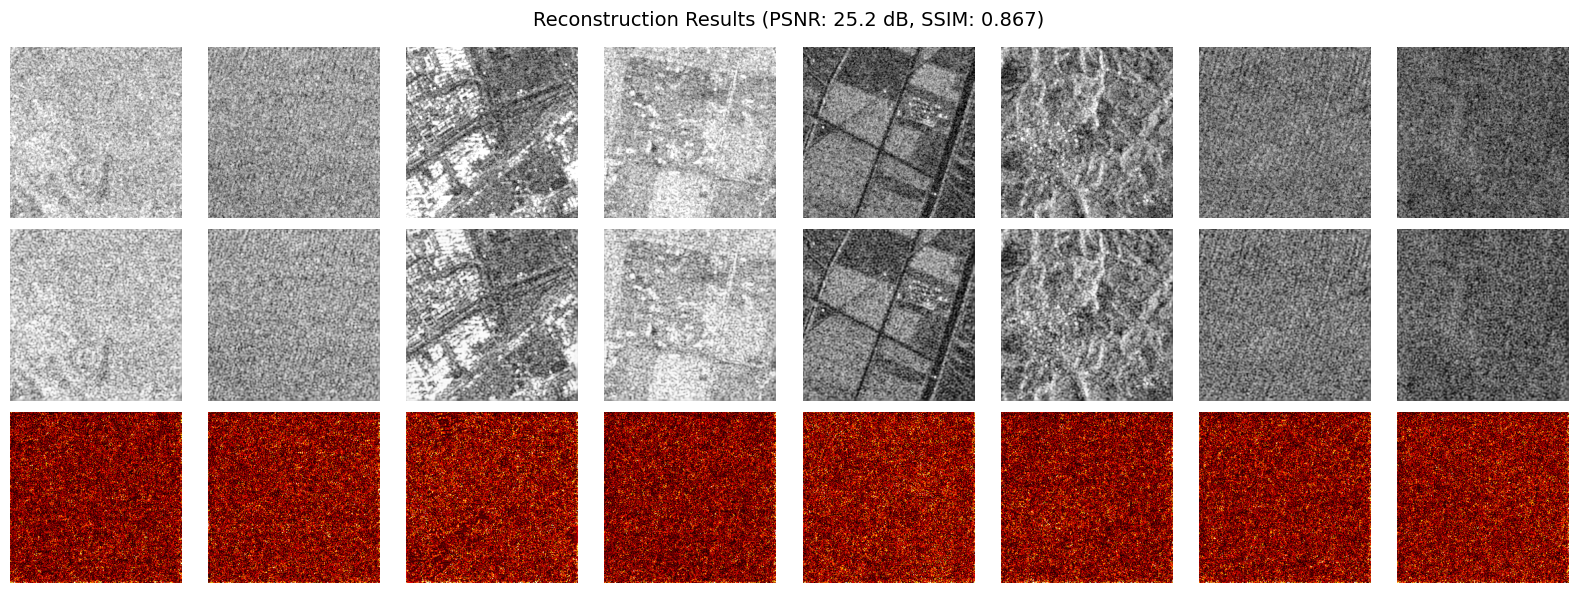

In [41]:
fig, axes = plt.subplots(3, 8, figsize=(16, 6))

for i in range(8):
    # Original
    axes[0, i].imshow(sample[i, 0].cpu(), cmap='gray', vmin=0, vmax=1)
    axes[0, i].axis('off')
    if i == 0: axes[0, i].set_ylabel('Original', fontsize=12)
    
    # Reconstructed
    axes[1, i].imshow(recon[i, 0].cpu(), cmap='gray', vmin=0, vmax=1)
    axes[1, i].axis('off')
    if i == 0: axes[1, i].set_ylabel('Reconstructed', fontsize=12)
    
    # Difference
    diff = torch.abs(sample[i, 0] - recon[i, 0]).cpu()
    axes[2, i].imshow(diff, cmap='hot', vmin=0, vmax=0.2)
    axes[2, i].axis('off')
    if i == 0: axes[2, i].set_ylabel('Difference', fontsize=12)

plt.suptitle(f'Reconstruction Results (PSNR: {metrics["psnr"]:.1f} dB, SSIM: {metrics["ssim"]:.3f})', fontsize=14)
plt.tight_layout()
plt.savefig(project_root / 'checkpoints' / 'reconstruction_samples.png', dpi=150)
plt.show()

Latent shape: torch.Size([8, 64, 16, 16])
Latent stats: mean=-0.006, std=4.646


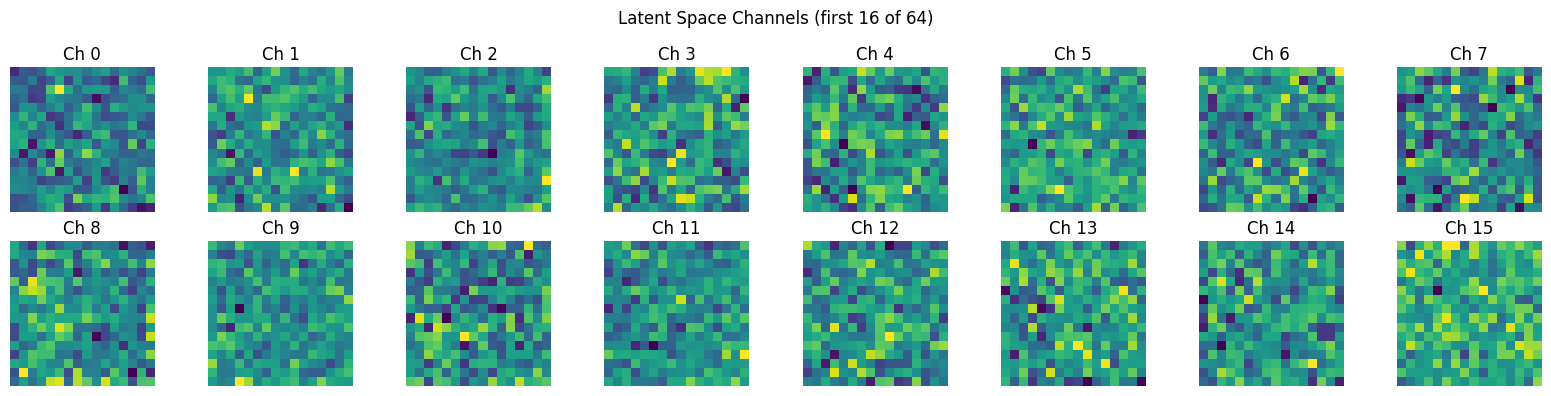

In [42]:
print(f"Latent shape: {latent.shape}")
print(f"Latent stats: mean={latent.mean():.3f}, std={latent.std():.3f}")

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    axes[0, i].imshow(latent[0, i].cpu(), cmap='viridis')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Ch {i}')
    
    axes[1, i].imshow(latent[0, i+8].cpu(), cmap='viridis')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Ch {i+8}')

plt.suptitle('Latent Space Channels (first 16 of 64)', fontsize=12)
plt.tight_layout()
plt.show()

---

# Done!

If all tests pass and you can train, copy your implementations to:
- `src/models/blocks.py` → ConvBlock, DeconvBlock
- `src/models/encoder.py` → SAREncoder
- `src/models/decoder.py` → SARDecoder
- `src/models/autoencoder.py` → SARAutoencoder
- `src/losses/ssim.py` → SSIMLoss
- `src/losses/combined.py` → CombinedLoss
- `src/training/trainer.py` → training functions

---

# Part 7: Comprehensive Evaluation

Run this after training to get detailed metrics and visualisations.

COMPREHENSIVE MODEL EVALUATION
Results will be saved to: d:\Projects\CNNAutoencoderProject\results\eval_20260120_223739

[1/4] Evaluating reconstruction quality on validation set...
Evaluating dataset...

EVALUATION REPORT

Reconstruction Quality Metrics:
--------------------------------------------------
Metric                Mean        Std        Min        Max
--------------------------------------------------
PSNR               25.2599     0.0658    25.0899    25.4406
SSIM                0.8791     0.0029     0.8700     0.8866
MSE                 0.0030     0.0000     0.0029     0.0031
MAE                 0.0425     0.0003     0.0416     0.0434
EPI                 0.9724     0.0027     0.9642     0.9796
HIST_SIM            0.7293     0.0187     0.6811     0.7839

[2/4] Analysing latent space...

Latent Space Statistics:
----------------------------------------
  Global mean:      -0.0226
  Global std:       4.8380
  Range:            [-27.7486, 29.5171]
  Sparsity:         1.9% ne

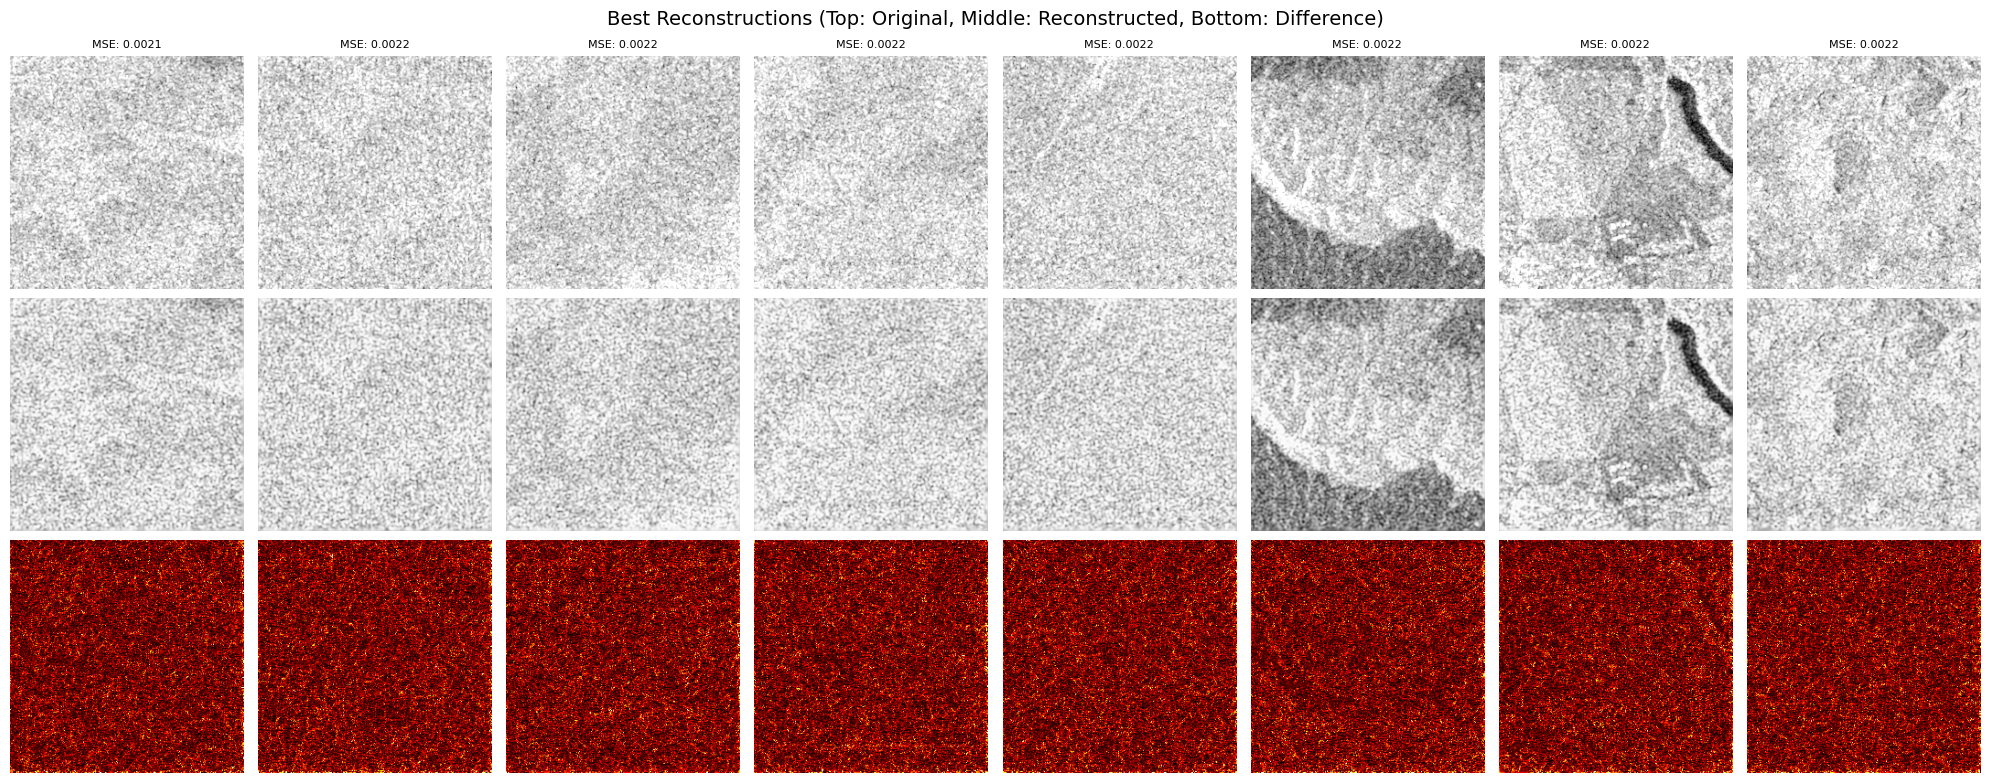

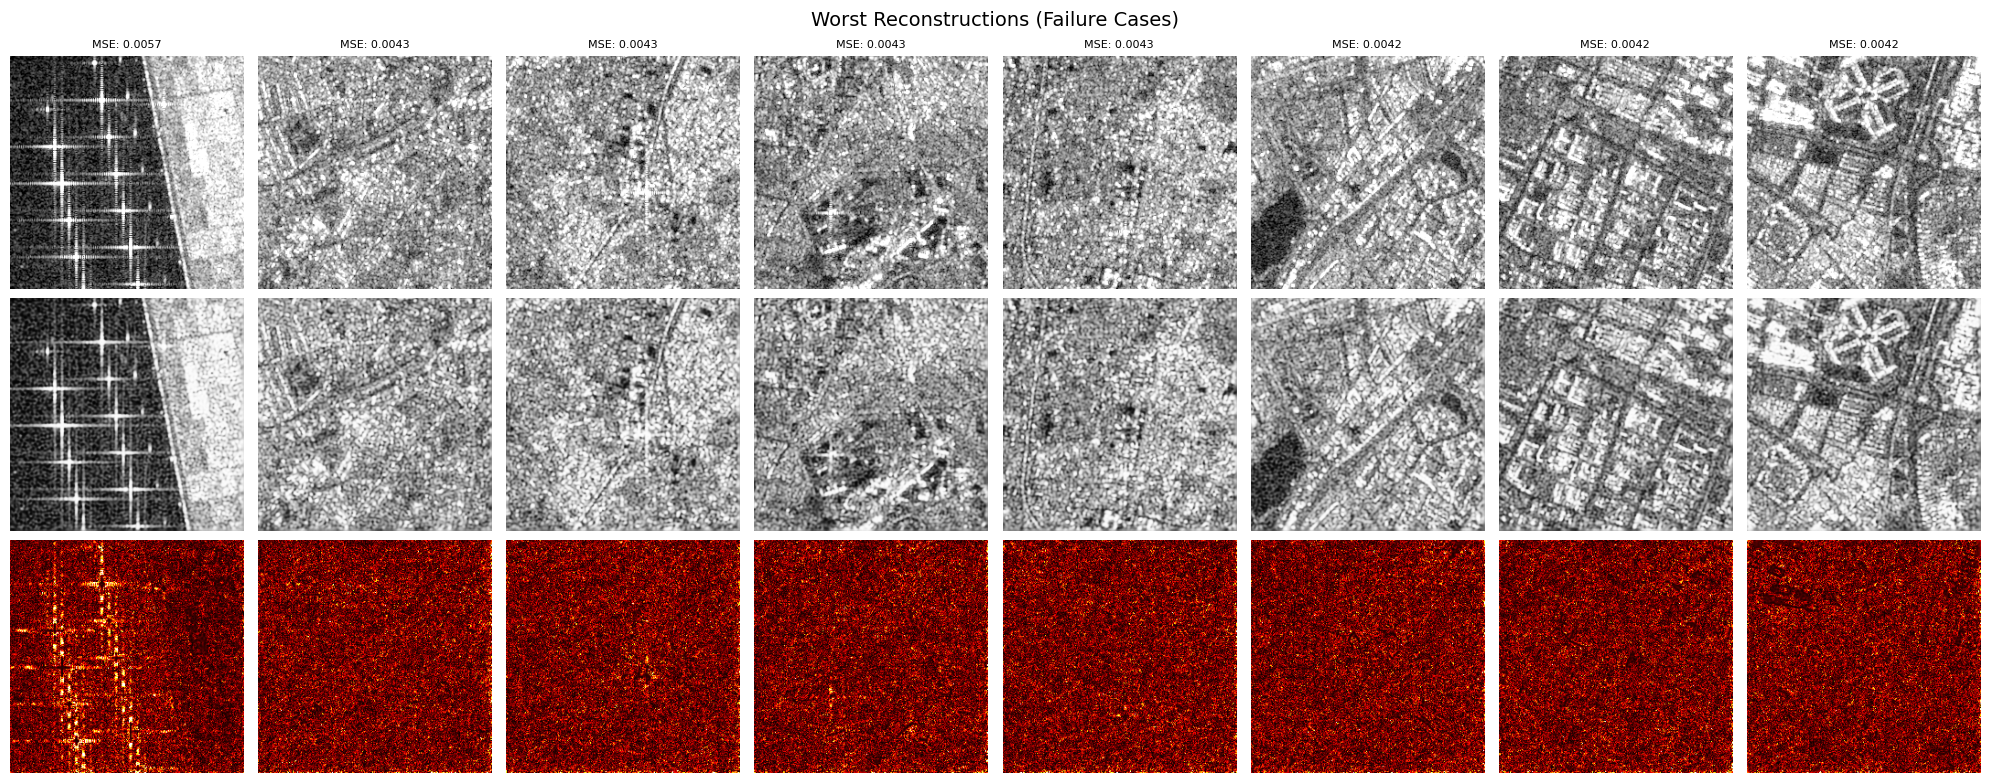


Latent space visualisation (first sample):


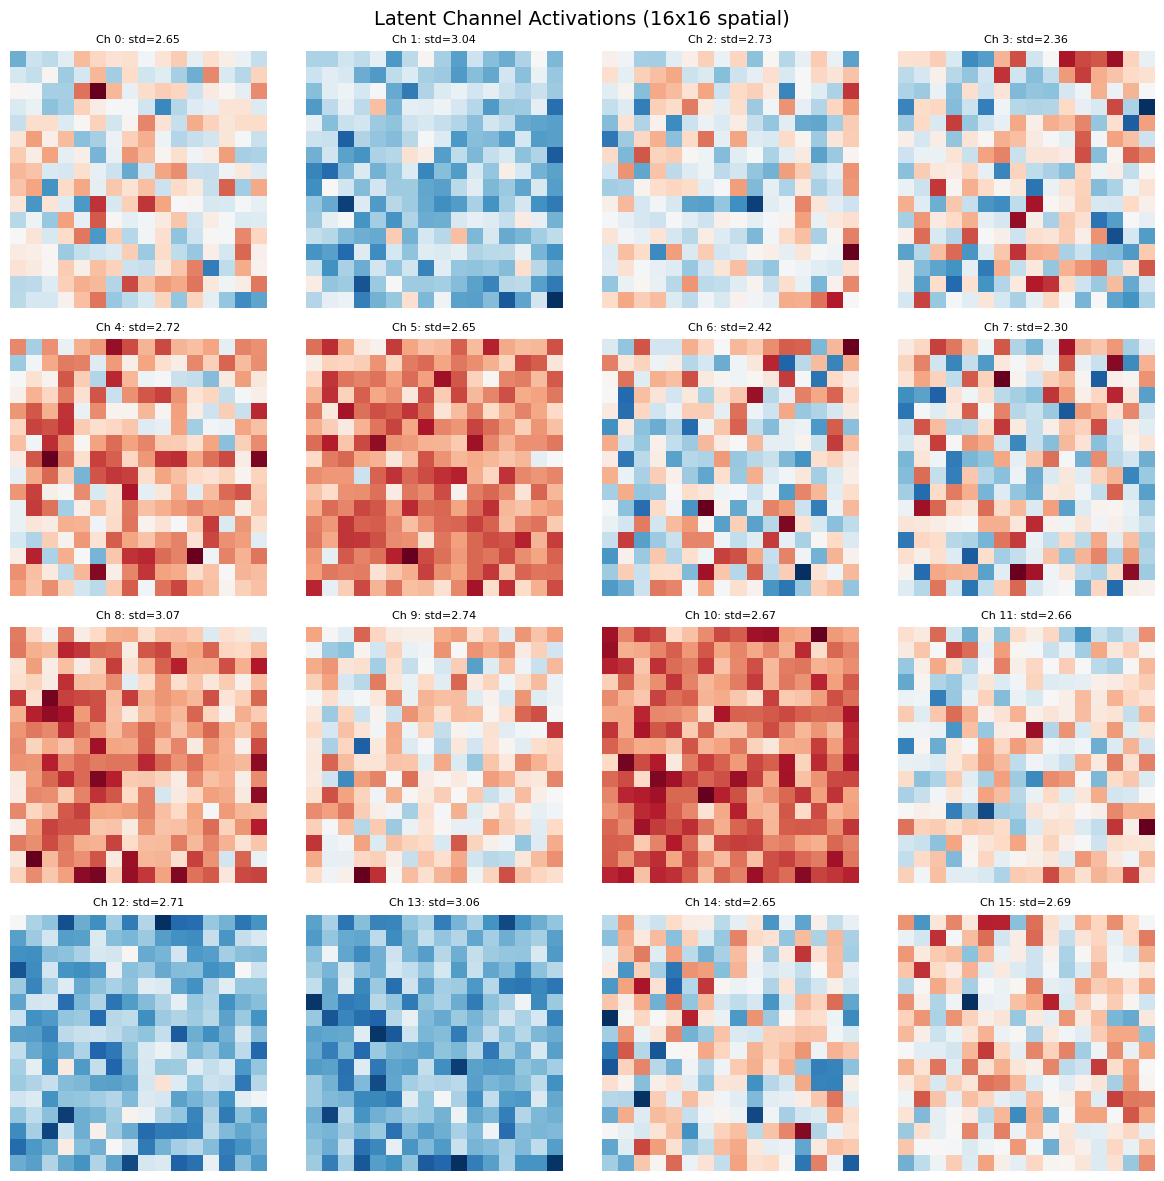


EVALUATION SUMMARY
Average PSNR:  25.26 dB (std: 0.07)
Average SSIM:  0.8791 (std: 0.0029)
Average MSE:   0.002992
Edge Preservation Index: 0.9724
Histogram Similarity:    0.7293

Results saved to:
  - d:\Projects\CNNAutoencoderProject\results\eval_20260120_223739\evaluation_results.json
  - d:\Projects\CNNAutoencoderProject\results\eval_20260120_223739\best_reconstructions.png
  - d:\Projects\CNNAutoencoderProject\results\eval_20260120_223739\worst_reconstructions.png
  - d:\Projects\CNNAutoencoderProject\results\eval_20260120_223739\latent_channels.png
  - d:\Projects\CNNAutoencoderProject\results\evaluation_history.csv (appended)

Run ID: eval_20260120_223739


In [43]:
# =============================================================================
# COMPREHENSIVE MODEL EVALUATION WITH SAVING
# =============================================================================

import sys
import json as json_module
from datetime import datetime
from pathlib import Path

sys.path.insert(0, str(project_root))

from src.evaluation.evaluator import Evaluator, SARMetrics, print_evaluation_report
from src.evaluation.visualizer import Visualizer

print("=" * 70)
print("COMPREHENSIVE MODEL EVALUATION")
print("=" * 70)

# Create results directory
results_dir = project_root / "results"
results_dir.mkdir(exist_ok=True)

# Generate unique run ID
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_id = f"eval_{timestamp}"
run_dir = results_dir / run_id
run_dir.mkdir(exist_ok=True)

print(f"Results will be saved to: {run_dir}")

# Create evaluator
evaluator = Evaluator(model, device=device)

# 1. Evaluate on validation set
print()
print("[1/4] Evaluating reconstruction quality on validation set...")
results = evaluator.evaluate_dataset(val_loader)
print_evaluation_report(results)

# 2. Analyse latent space
print()
print("[2/4] Analysing latent space...")
latent_stats = evaluator.analyze_latent_space(val_loader, n_batches=10)
print()
print("Latent Space Statistics:")
print("-" * 40)
print(f"  Global mean:      {latent_stats['global_mean']:.4f}")
print(f"  Global std:       {latent_stats['global_std']:.4f}")
print(f"  Range:            [{latent_stats['min']:.4f}, {latent_stats['max']:.4f}]")
print(f"  Sparsity:         {latent_stats['sparsity']*100:.1f}% near zero")
print(f"  Active channels:  {latent_stats['active_channels']}/{latent_stats['total_channels']}")

# 3. Find best and worst cases
print()
print("[3/4] Finding best and worst reconstructions...")
worst_cases = evaluator.find_failure_cases(val_loader, n_worst=8)
best_cases = evaluator.find_best_cases(val_loader, n_best=8)

print()
print("Worst reconstructions (highest MSE):")
for i, case in enumerate(worst_cases[:5]):
    print(f"  {i+1}. MSE = {case['mse']:.6f}")

print()
print("Best reconstructions (lowest MSE):")
for i, case in enumerate(best_cases[:5]):
    print(f"  {i+1}. MSE = {case['mse']:.6f}")

# 4. Visualise and save results
print()
print("[4/4] Generating and saving visualisations...")

# Plot best reconstructions
fig, axes = plt.subplots(3, 8, figsize=(20, 8))
fig.suptitle('Best Reconstructions (Top: Original, Middle: Reconstructed, Bottom: Difference)', fontsize=14)

for i in range(min(8, len(best_cases))):
    orig = best_cases[i]['original'].numpy().squeeze()
    recon = best_cases[i]['reconstructed'].numpy().squeeze()
    diff = np.abs(orig - recon)

    axes[0, i].imshow(orig, cmap='gray', vmin=0, vmax=1)
    axes[0, i].axis('off')
    axes[0, i].set_title(f"MSE: {best_cases[i]['mse']:.4f}", fontsize=8)

    axes[1, i].imshow(recon, cmap='gray', vmin=0, vmax=1)
    axes[1, i].axis('off')

    axes[2, i].imshow(diff, cmap='hot', vmin=0, vmax=0.2)
    axes[2, i].axis('off')

plt.tight_layout()
plt.savefig(run_dir / 'best_reconstructions.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot worst reconstructions
fig, axes = plt.subplots(3, 8, figsize=(20, 8))
fig.suptitle('Worst Reconstructions (Failure Cases)', fontsize=14)

for i in range(min(8, len(worst_cases))):
    orig = worst_cases[i]['original'].numpy().squeeze()
    recon = worst_cases[i]['reconstructed'].numpy().squeeze()
    diff = np.abs(orig - recon)

    axes[0, i].imshow(orig, cmap='gray', vmin=0, vmax=1)
    axes[0, i].axis('off')
    axes[0, i].set_title(f"MSE: {worst_cases[i]['mse']:.4f}", fontsize=8)

    axes[1, i].imshow(recon, cmap='gray', vmin=0, vmax=1)
    axes[1, i].axis('off')

    axes[2, i].imshow(diff, cmap='hot', vmin=0, vmax=0.3)
    axes[2, i].axis('off')

plt.tight_layout()
plt.savefig(run_dir / 'worst_reconstructions.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot latent channels
print()
print("Latent space visualisation (first sample):")
with torch.no_grad():
    sample = next(iter(val_loader))[:1].to(device)
    _, latent = model(sample)
    latent_np = latent[0].cpu().numpy()

n_channels = min(16, latent_np.shape[0])
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle('Latent Channel Activations (16x16 spatial)', fontsize=14)

for i, ax in enumerate(axes.flatten()):
    if i < n_channels:
        channel = latent_np[i]
        vmax = max(abs(channel.min()), abs(channel.max()), 0.1)
        im = ax.imshow(channel, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
        ax.set_title(f'Ch {i}: std={channel.std():.2f}', fontsize=8)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.savefig(run_dir / 'latent_channels.png', dpi=150, bbox_inches='tight')
plt.show()

# =============================================================================
# SAVE ALL RESULTS TO JSON
# =============================================================================

# Collect all evaluation data
evaluation_data = {
    'run_id': run_id,
    'timestamp': timestamp,
    'date': datetime.now().isoformat(),

    # Model configuration
    'model_config': {
        'latent_channels': model.latent_channels,
        'base_channels': model.base_channels if hasattr(model, 'base_channels') else 64,
        'compression_ratio': model.get_compression_ratio(),
        'total_parameters': sum(p.numel() for p in model.parameters()),
        'encoder_parameters': sum(p.numel() for p in model.encoder.parameters()),
        'decoder_parameters': sum(p.numel() for p in model.decoder.parameters()),
    },

    # Training settings
    'training_config': {
        'batch_size': config.get('batch_size', 'unknown'),
        'learning_rate': config.get('learning_rate', 'unknown'),
        'mse_weight': config.get('mse_weight', 'unknown'),
        'ssim_weight': config.get('ssim_weight', 'unknown'),
        'max_grad_norm': config.get('max_grad_norm', 'unknown'),
        'lr_factor': config.get('lr_factor', 'unknown'),
        'lr_patience': config.get('lr_patience', 'unknown'),
    },

    # Training results
    'training_results': {
        'epochs_trained': trainer.epoch + 1 if 'trainer' in dir() else 'unknown',
        'best_val_loss': float(trainer.best_val_loss) if 'trainer' in dir() else 'unknown',
    },

    # Dataset info
    'dataset': {
        'train_size': len(train_loader.dataset),
        'val_size': len(val_loader.dataset),
        'patch_size': 256,
    },

    # Reconstruction metrics
    'metrics': {
        'psnr': results['psnr'],
        'ssim': results['ssim'],
        'mse': results['mse'],
        'mae': results['mae'],
        'epi': results['epi'],
        'histogram_similarity': results['hist_sim'],
    },

    # Latent space statistics
    'latent_space': latent_stats,

    # Best/worst case MSE values
    'best_cases_mse': [case['mse'] for case in best_cases],
    'worst_cases_mse': [case['mse'] for case in worst_cases],
}

# Save to JSON
results_file = run_dir / 'evaluation_results.json'
with open(results_file, 'w') as f:
    json_module.dump(evaluation_data, f, indent=2)

print()
print("=" * 70)
print("EVALUATION SUMMARY")
print("=" * 70)
print(f"Average PSNR:  {results['psnr']['mean']:.2f} dB (std: {results['psnr']['std']:.2f})")
print(f"Average SSIM:  {results['ssim']['mean']:.4f} (std: {results['ssim']['std']:.4f})")
print(f"Average MSE:   {results['mse']['mean']:.6f}")
print(f"Edge Preservation Index: {results['epi']['mean']:.4f}")
print(f"Histogram Similarity:    {results['hist_sim']['mean']:.4f}")
print("=" * 70)

# =============================================================================
# APPEND TO MASTER COMPARISON CSV
# =============================================================================

import csv

csv_file = results_dir / 'evaluation_history.csv'
csv_exists = csv_file.exists()

# Flatten metrics for CSV
csv_row = {
    'run_id': run_id,
    'timestamp': timestamp,
    'latent_channels': model.latent_channels,
    'compression_ratio': model.get_compression_ratio(),
    'total_params': sum(p.numel() for p in model.parameters()),
    'batch_size': config.get('batch_size', ''),
    'learning_rate': config.get('learning_rate', ''),
    'mse_weight': config.get('mse_weight', ''),
    'ssim_weight': config.get('ssim_weight', ''),
    'train_size': len(train_loader.dataset),
    'val_size': len(val_loader.dataset),
    'psnr_mean': results['psnr']['mean'],
    'psnr_std': results['psnr']['std'],
    'ssim_mean': results['ssim']['mean'],
    'ssim_std': results['ssim']['std'],
    'mse_mean': results['mse']['mean'],
    'mae_mean': results['mae']['mean'],
    'epi_mean': results['epi']['mean'],
    'hist_sim_mean': results['hist_sim']['mean'],
    'latent_sparsity': latent_stats['sparsity'],
    'active_channels': latent_stats['active_channels'],
    'best_val_loss': float(trainer.best_val_loss) if 'trainer' in dir() else '',
}

with open(csv_file, 'a', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=csv_row.keys())
    if not csv_exists:
        writer.writeheader()
    writer.writerow(csv_row)

print()
print("Results saved to:")
print(f"  - {results_file}")
print(f"  - {run_dir / 'best_reconstructions.png'}")
print(f"  - {run_dir / 'worst_reconstructions.png'}")
print(f"  - {run_dir / 'latent_channels.png'}")
print(f"  - {csv_file} (appended)")
print()
print(f"Run ID: {run_id}")
print("=" * 70)
